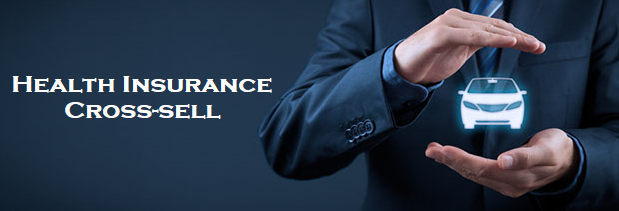

In [7]:
Image("../images/hics.png", width=1700)

# <font color='darkblue'> 0.0. Bussiness Questions </font>

**The Insurance All Company**

Insurance All is a company that provides health insurance to its customers and the product team is analyzing the possibility of offering policyholders a new product: A car insurance.

As with health insurance, customers of this new car insurance plan must pay an amount annually to Insurance All in order to obtain an amount insured by the company, destined to the costs of an eventual accident or damage to the vehicle.

Insurance All surveyed nearly 380,000 customers about interest in joining a new auto insurance product last year. All customers showed interest or not in purchasing auto insurance and these responses were saved in a database along with other customer attributes.

The product team selected 127,000 new customers who did not respond to the survey to participate in a campaign, in which they will receive an offer of the new car insurance product. The offer will be made by the sales team through phone calls.

However, the sales team has the capacity to make 20,000 calls within the campaign period.

**The Challenge**

In this context, you were hired as a Data Science consultant to build a model that predicts whether or not the customer would be interested in auto insurance.

With its solution, the sales team hopes to be able to prioritize people with the greatest interest in the new product and thus optimize the campaign by only making contact with the customers most likely to make a purchase.

As a result of your consultancy, you will need to deliver a report containing some analysis and answers to the following questions:

**1. Key Insights on the most relevant attributes of customers interested in purchasing auto insurance.**

**2. What percentage of customers interested in purchasing auto insurance will the sales team be able to reach by making 20,000 calls?**

**3. And if the sales team capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?**

**4. How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?**

# <font color='darkblue'> 1.0. Planning </font>

- Cycle 00
    - Understand about the business
    - Understand the business questions
    - Define what will be delivered at the end of the project
    - Plan how the solution will be built
    - Check what data we have to analyze the project's feasibility
    
- Cycle 01
    - Collect the data
    - Clear the data
    - Split and Prepare data for ML
    - Apply some ML templates
    - Define and apply metrics
    
- Cycle 02
    - Check if you need balancing
    - Perform descriptive analysis
    - Filter data depending on business limitations
    - Make the mental map and raise hypotheses
    - Perform Feature Engineering
    - Perform EDA - Univariate Analysis
    - Make Feature Selection
    - Perform cross-validation
    - Check for changes in results

- Cycle 03
    - Perform EDA - Bivariate Analysis
    - Perform EDA - Multivariate Analysis
    - Confronting the Selection of Algorithm Features with the knowledge extracted from the EDA
    - Check if you need to change anything in the preparation
    - Choose the model and optimize the hyperparameters
    - Apply test data and compare results to check if you overfit

- Cycle 04
    - Review the entire project to analyze possible improvements
    - After improvements or if there are none, answer business questions
    - Deploy

# <font color='darkblue'> 2.0. Data Collection </font>

## 2.1. Imports

In [4]:
import sys

# data serializer
import pickle

# SQL 
import os
import psycopg2

# Kaggle's API Request
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

# Data manipulation
import numpy  as np
import pandas as pd

# Data visualization
import seaborn           as sns
import matplotlib.pyplot as plt
from   tabulate          import tabulate

# ML Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import MinMaxScaler, StandardScaler, RobustScaler

# ML Algorithms
from sklearn.naive_bayes  import GaussianNB
from xgboost              import XGBClassifier
from lightgbm             import LGBMClassifier
from catboost             import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.ensemble     import RandomForestClassifier, ExtraTreesClassifier

# Metrics
import scikitplot as skplt
from sklearn.model_selection import StratifiedKFold

# Notebook configuration
from IPython.core.display import HTML

# hide warnings
import warnings

# Hyperparameter Fine Tuning
from skopt import BayesSearchCV

# statistics
import scipy.stats as ss

# load images
from IPython.display import Image

In [7]:
# hide warnings
warnings.filterwarnings('ignore')

## 2.2. SQL (Train & Test Data)

In [10]:
# Get environment variables
HOST = os.getenv('DB_HOST')
PORT = int(os.getenv('DB_PORT'))
DATABASE = os.getenv('DB_DATABASE')
USERNAME = os.getenv('DB_USER') 
PASSWORD = os.getenv('DB_PASSWORD')

In [11]:
# connect to database
connection = psycopg2.connect(user = USERNAME,
                              password = PASSWORD,
                              host = HOST,
                              port = PORT,
                              database = DATABASE)

In [12]:
# query to select schemas from bd
query = '''
            SELECT schema_name
            FROM information_schema.schemata;
        '''

# convert sql in a dataframe
db_schemas = pd.read_sql(query, connection)
db_schemas

,schema_name
0,pg_catalog
1,information_schema
2,public
3,pa004


In [13]:
# query to access tables of pa004 schema
query = '''
            SELECT *
            FROM pg_catalog.pg_tables
            WHERE schemaname = 'pa004';
        '''

# convert sql in a dataframe
db_tables = pd.read_sql(query, connection)
db_tables[['schemaname', 'tablename']]

,schemaname,tablename
0,pa004,users
1,pa004,vehicle
2,pa004,insurance


In [14]:
# query to get the data from users table
query = '''
            SELECT *
            FROM pa004.users;
        '''

# convert sql in a dataframe
df_users = pd.read_sql(query, connection)
df_users.head()

,id,gender,age,region_code,policy_sales_channel
0,1,Male,44,28.0,26.0
1,2,Male,76,3.0,26.0
2,3,Male,47,28.0,26.0
3,4,Male,21,11.0,152.0
4,5,Female,29,41.0,152.0


In [15]:
# query to get the data from vehicle table
query = '''
            SELECT *
            FROM pa004.vehicle;
        '''

# convert sql in a dataframe
df_vehicle = pd.read_sql(query, connection)
df_vehicle.head()

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No


In [16]:
# query to get the data from insurance table
query = '''
            SELECT *
            FROM pa004.insurance;
        '''

# convert sql in a dataframe
df_insurance = pd.read_sql(query, connection)
df_insurance.head()

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.0,217,1
1,2,0,33536.0,183,0
2,3,0,38294.0,27,1
3,4,1,28619.0,203,0
4,5,1,27496.0,39,0


In [17]:
# close db connection 
connection.close()

In [18]:
# check dataframe shapes
print('df_users shape:', df_vehicle.shape)
print('df_vehicle shape:', df_vehicle.shape)
print('df_insurance shape:', df_insurance.shape)

df_users shape: (381109, 4)
df_vehicle shape: (381109, 4)
df_insurance shape: (381109, 5)


In [19]:
# check if id column is the same on every dataframe
print('users[id] vs vehicle[id]:', df_users['id'].equals(df_vehicle['id']))
print('vehicle[id] vs insurance [id]:', df_vehicle['id'].equals(df_insurance['id']))
print('insurance[id] vs users [id]:', df_insurance['id'].equals(df_users['id']))

users[id] vs vehicle[id]: True
vehicle[id] vs insurance [id]: True
insurance[id] vs users [id]: True


In [26]:
# merge all dataframes on id columns
df_aux = pd.merge(df_users, df_vehicle, on = 'id', how = 'inner')
df_init = pd.merge(df_aux, df_insurance, on = 'id', how = 'inner')

# # save pickle
# pickle.dump(df_init, open('../src/steps/df_init.pkl', 'wb'))

# load pickle
df_raw = pickle.load(open('../src/steps/df_init.pkl', 'rb'))

# show dataframe
df_raw

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26.0,26.0,1,1-2 Year,No,1,30170.0,88,0
381105,381106,Male,30,37.0,152.0,1,< 1 Year,No,1,40016.0,131,0
381106,381107,Male,21,30.0,160.0,1,< 1 Year,No,1,35118.0,161,0
381107,381108,Female,68,14.0,124.0,1,> 2 Years,Yes,0,44617.0,74,0


## 2.3. API Request (Production Data)

In [35]:
# Init Kaggle's API
api = KaggleApi()

# Authenticate API
api.authenticate()

In [36]:
# download test data from kaggle
api.dataset_download_file('anmolkumar/health-insurance-cross-sell-prediction', 'test.csv')

True

In [37]:
# unzip test data
with zipfile.ZipFile('test.csv.zip', 'r') as zipref:
    zipref.extractall("../data/")

## 2.4. Helper Functions & Settings

In [38]:
def cross_validation(model, model_name, x_train, y_train, num_folds):
    # generate k-fold   
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
    
    # save k-fold's prediction
    precisionatk_list_cv = []

    for train_cv, val_cv in kfold.split(x_train, y_train):
    
        # get fold
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        # model definition
        model_fold = model

        # training model
        model_fold.fit(x_train_fold, y_train_fold)

        # prediction
        y_pred_fold = model_fold.predict_proba(x_val_fold)

        ## precision @K
        # size of true values from target dataset
        k_size = len(y_val_fold[y_val_fold == 1])

        # add y_val to data to create score metrics 
        x_val_fold['response'] = y_val_fold.copy()

        # propensity score
        x_val_fold['propensity_score'] = y_pred_fold[:, 1].tolist()

        # compute precision at k
        precisionatk_cv = precision_at_k(x_val_fold, k=k_size)
        precisionatk_list_cv.append(precisionatk_cv)
    
    # save data
    precision_at_k_cv_mean = np.mean(precisionatk_list_cv)
    precision_at_k_cv_std = np.std(precisionatk_list_cv)
         
    return y_pred_fold, pd.DataFrame({'Model': model_name , 
                                      'Precision@k_CV': precision_at_k_cv_mean,
                                      'CV_STD': precision_at_k_cv_std}, index=[0])

In [39]:
def precision_at_k(data, k=2000):
    # sort clients by propensity score
    data = data.sort_values('propensity_score', ascending=False)
    
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1
    
    # calc precision_at_k
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

In [40]:
def get_size(model):
    
    # save model in a pickle object
    obj = pickle.dumps(model)
    
    # get the size in bytes of this object
    bytes_size = sys.getsizeof(obj)
    
    # convert to megabytes
    model_size = bytes_size / (1024*1024)
    
    return model_size

In [41]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
   
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
        
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [42]:
def cramers_v_df(categorical_features):

    rows= []

    for var1 in categorical_features:

        col = []

        for var2 in categorical_features:
            cramers =cramer_v(categorical_features[var1], categorical_features[var2]) 
            col.append(round(cramers,3)) 

        rows.append(col)

    cramers_results = np.array(rows)
    df = pd.DataFrame(cramers_results, columns=categorical_features.columns, index=categorical_features.columns)

    return df

In [43]:
# float numbers configuration
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [44]:
# Notebook configuration
display( HTML( '<style>.container { width:100% !important; }</style>') )

# <font color='darkblue'> 3.0. Data Cleaning & Description </font>

## 3.1. Split Data into Train(90%) & Test(10%)

In [57]:
# Divide into X and y
X_raw = df_raw.drop('response', axis=1)
y_raw = df_raw['response'].copy()

In [58]:
# Split into Train & Test
x_df1, x_test, y_df1, y_test = train_test_split(X_raw, y_raw, test_size=0.1, random_state=42)

In [59]:
# # Concatenate X and y of Train dataset
# df1 = pd.concat([x_df1, y_df1], axis=1).reset_index(drop=True)
# 
# # save pickle
# pickle.dump(df1, open('../src/steps/df1.pkl', 'wb'))

In [60]:
# load pickle
df1 = pickle.load(open('../src/steps/df1.pkl', 'rb'))

In [61]:
df1

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,273484,Male,59,28.000,26.000,1,1-2 Year,Yes,0,21261.000,144,0
1,371247,Female,42,1.000,124.000,1,1-2 Year,Yes,0,2630.000,211,0
2,90690,Male,23,18.000,152.000,1,< 1 Year,No,1,29869.000,80,0
3,94810,Female,25,47.000,152.000,1,< 1 Year,Yes,0,42822.000,199,0
4,50506,Male,55,26.000,22.000,1,1-2 Year,No,1,33225.000,230,0
...,...,...,...,...,...,...,...,...,...,...,...,...
342993,259179,Female,24,36.000,152.000,1,< 1 Year,No,1,22575.000,287,0
342994,365839,Male,56,35.000,124.000,1,1-2 Year,Yes,0,41287.000,298,0
342995,131933,Female,22,2.000,152.000,1,< 1 Year,Yes,0,18857.000,76,0
342996,146868,Male,44,32.000,156.000,1,1-2 Year,Yes,1,2630.000,51,0


## 3.2. Columns Description

**Id**: Unique ID for the customer.

**Gender**: Gender of the customer.

**Age**: Age of the customer.

**Driving License**: 0: Customer does not have DL. 1: Customer already has DL.

**Region Code**: Unique code for the region of the customer.

**Previously Insured**: 0: Customer does not have auto insurance. 1: Customer already has auto insurance.

**Vehicle Age**: Age of the Vehicle.

**Vehicle Damage**: 1: Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.

**Annual Premium**: Amount the customer paid the company for annual health insurance.

**Policy sales channel**: Anonymous code for the customer contact channel.

**Vintage**: Number of days that the customer was associated with the company through the purchase of health insurance.

**Response**: 0: The customer is not interested. 1: The customer is interested.

## 3.3. Data Dimensions

In [62]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of cols: {df1.shape[1]}')

Number of rows: 342998
Number of cols: 12


## 3.4. Check Data Types

In [63]:
# change region_code from float to int format
df1['region_code'] = df1['region_code'].astype('int64')

# change policy_sales_channel from float to int format
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

- change region_code from **float** to **int** format

- change policy_sales_channel from **float** to **int** format

## 3.5. Check NA

In [64]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 3.6. Check Values

In [65]:
# df1['gender'].unique()
# df1['age'].unique()
# df1['region_code'].unique()
# df1['policy_sales_channel'].unique()
# df1['driving_license'].unique()
# df1['vehicle_age'].unique()
# df1['vehicle_damage'].unique()
# df1['previously_insured'].unique()
# df1['annual_premium'].max()
# df1['vintage'].unique()
# df1['response'].unique()

## 3.7. Check Data Types 

In [66]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code               int64
policy_sales_channel      int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 3.8. Descriptive Statistics

### 3.8.1. Numerical Features

In [67]:
num_attributes = df1[['id', 'age', 'region_code', 'policy_sales_channel', 'annual_premium', 'vintage']]
cat_attributes = df1[['id', 'gender', 'driving_license', 'vehicle_age', 'vehicle_damage', 'previously_insured', 'response']]

# central tendency metrics
mean_     = pd.DataFrame(num_attributes.mean()).T
median_   = pd.DataFrame(num_attributes.median()).T

# dispersion metrics
min_      = pd.DataFrame(num_attributes.min()).T
max_      = pd.DataFrame(num_attributes.max()).T
range_    = pd.DataFrame(num_attributes.max() - num_attributes.min()).T
std_      = pd.DataFrame(num_attributes.std()).T
skew_     = pd.DataFrame(num_attributes.skew()).T
kurtosis_ = pd.DataFrame(num_attributes.kurtosis()).T


metrics = pd.concat([min_, max_, range_, mean_, median_, std_, skew_, kurtosis_]).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis',  ]
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.000,381109.000,381108.000,190563.748,190562.500,109998.389,-0.000,-1.200
1,age,20.000,85.000,65.000,38.822,36.000,15.503,0.671,-0.567
2,region_code,0.000,52.000,52.000,26.395,28.000,13.223,-0.116,-0.867
3,policy_sales_channel,1.000,163.000,162.000,111.997,132.000,54.218,-0.899,-0.973
4,annual_premium,2630.000,540165.000,537535.000,30575.193,31681.000,17202.377,1.768,34.510
5,vintage,10.000,299.000,289.000,154.333,154.000,83.654,0.004,-1.200


The following numbers of **policy_sales_channel** don't exists: **5, 72, 77, 85, 141, 142, 161, 162**

The total unique values of this feature is **155** 

### 3.8.2. Categorical Features

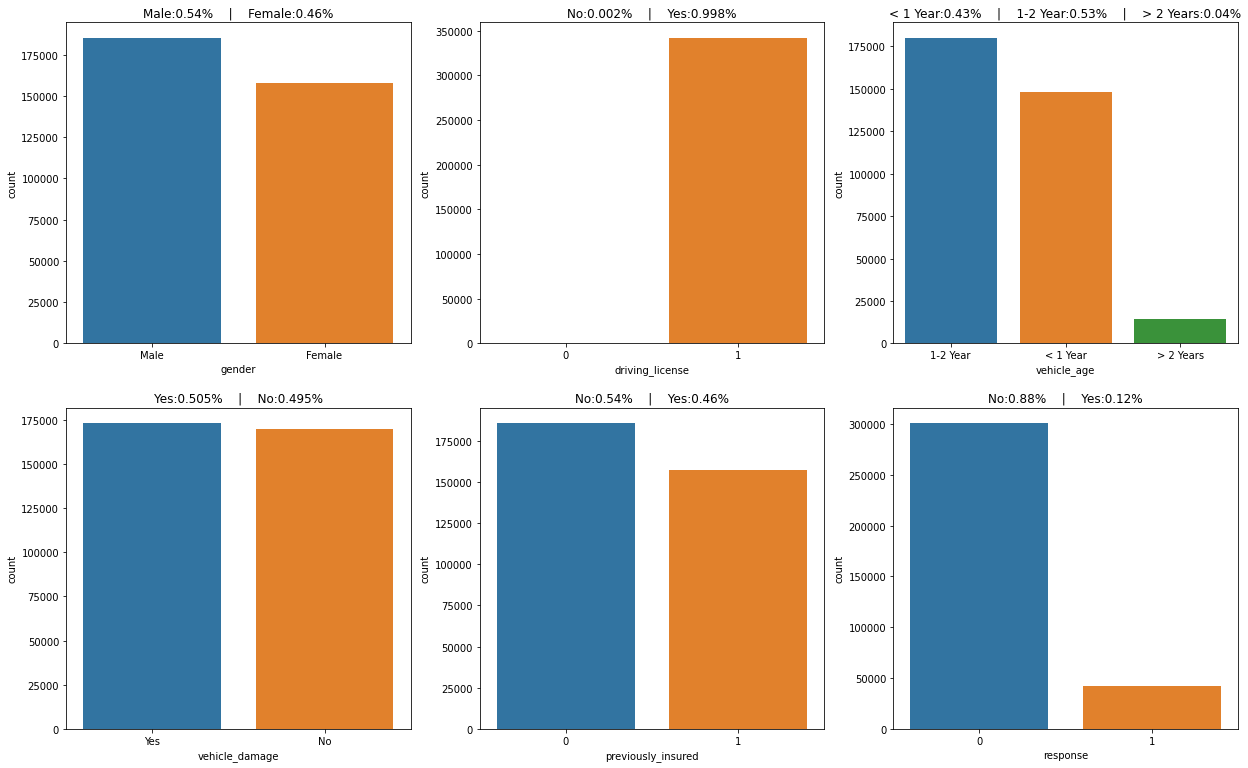

In [68]:
fig, axs = plt.subplots(2, 3, figsize = (21,13))

# gender plot
g_m, g_f = len(df1[df1["gender"] == "Male"]) / len(df1["gender"]), len(df1[df1["gender"] == "Female"]) / len(df1["gender"])
sns.countplot(x='gender', data=df1, ax=axs[0, 0]).set_title(f'Male:{g_m:.2f}%    |    Female:{g_f:.2f}%')

# driving license plot
dv_0, dv_1 = len(df1[df1["driving_license"] == 0]) / len(df1["driving_license"]), len(df1[df1["driving_license"] == 1]) / len(df1["driving_license"])
sns.countplot(x='driving_license', data=df1, ax=axs[0, 1]).set_title(f'No:{dv_0:.3f}%    |    Yes:{dv_1:.3f}%');
# vehicle age plot
dv_0, dv_1, dv_2 = len(df1[df1["vehicle_age"] == '< 1 Year']) / len(df1["vehicle_age"]), len(df1[df1["vehicle_age"] == '1-2 Year']) / len(df1["vehicle_age"]), len(df1[df1["vehicle_age"] == '> 2 Years']) / len(df1["vehicle_age"])
sns.countplot(x='vehicle_age', data=df1, ax=axs[0, 2]).set_title(f'< 1 Year:{dv_0:.2f}%    |    1-2 Year:{dv_1:.2f}%    |    > 2 Years:{dv_2:.2f}%');

# vehicle damage plot
vd_y, vd_n = len(df1[df1["vehicle_damage"] == "Yes"]) / len(df1["vehicle_damage"]), len(df1[df1["vehicle_damage"] == "No"]) / len(df1["vehicle_damage"])
sns.countplot(x='vehicle_damage', data=df1, ax=axs[1, 0]).set_title(f'Yes:{vd_y:.3f}%    |    No:{vd_n:.3f}%');

# previously insured plot
pi_0, pi_1 = len(df1[df1["previously_insured"] == 0]) / len(df1["previously_insured"]), len(df1[df1["previously_insured"] == 1]) / len(df1["previously_insured"])
sns.countplot(x='previously_insured', data=df1, ax=axs[1, 1]).set_title(f'No:{pi_0:.2f}%    |    Yes:{pi_1:.2f}%');

# response plot
r_0, r_1 = len(df1[df1["response"] == 0]) / len(df1["response"]), len(df1[df1["response"] == 1]) / len(df1["response"])
sns.countplot(x='response', data=df1, ax=axs[1, 2]).set_title(f'No:{r_0:.2f}%    |    Yes:{r_1:.2f}%');

# <font color='darkblue'> 4.0. Feature Engineering </font>

In [72]:
# # save pickle
# pickle.dump(df1, open('../src/steps/df2.pkl', 'wb')) 

# load pickle
df2 = pickle.load(open('../src/steps/df2.pkl', 'rb'))

## 4.1. Mind Map Hypotheses

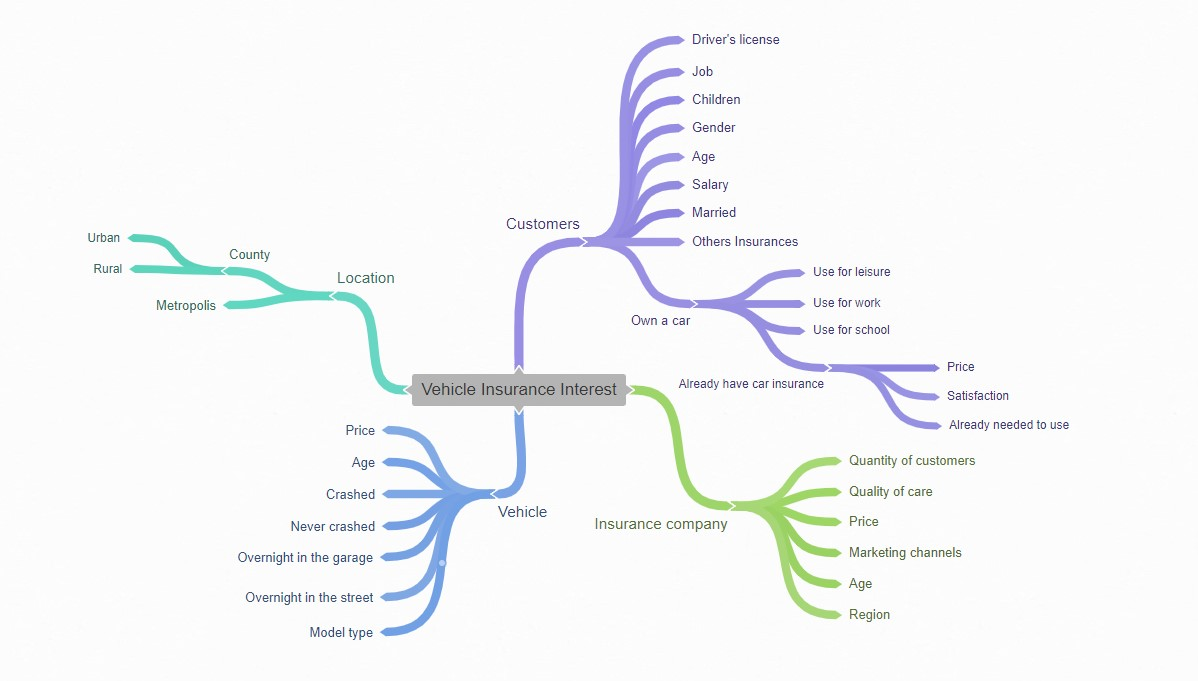

In [73]:
Image("../images/vehicle_insurance_interest_fluxogram.jpg")

## 4.2. Create Hypotheses

### 4.2.1. Customers

- Customers who have a driver's license correspond to 95% of those interested in vehicle insurance
- Clients who work correspond to 80% of those interested in vehicle insurance
- Customers with children are more interested in vehicle insurance
- Female customers are more interested in vehicle insurance
- Customers over 60 years old are the least interested in vehicle insurance
- Customers between 27 and 59 years old are most interested in vehicle insurance
- Customers with higher salaries are the most interested in vehicle insurance
- Married customers are more interested in vehicle insurance
- 70% of customers who have others insurances than the health's one, are interested in vehicle insurance
- Customers who already own a car correspond to 90% of those interested in vehicle insurance
- Customers who use their car for work are the most interested in vehicular insurance, followed by those who use it for studies and lastly only those who use it only for leisure
- Customers who already have vehicle insurance correspond to less than 10% of those interested
- Customers who already needed to call other insurances are more interested in vehicle insurance
- Of the customers who already have vehicle insurance and are interested in a new one, most find the current insurance to be expensive
- Of the customers who already have vehicle insurance and are interested in a new one, the majority is because they are not satisfied with the service
- Customers who are in the base for a period longer than the average are more interested in vehicle insurance

### 4.2.2. Location

- Customers who live in a metropolis correspond to more than 70% of those interested
- Clients who live in the rural area of ​​a municipality are less interested in vehicle insurance than clients who live in an urban area of ​​the municipality

### 4.2.3. Vehicle

- Customers who own cars that cost less than the average price are less interested in vehicle insurance
- Customers who own cars up to 2 years old correspond to more than 80% of those interested
- Customers who had their car crashed correspond to more than 90% of those interested in vehicular insurance
- Customers who own cars that overnight on the street correspond to 60% of those interested
- Customers who own sedan cars are more interested in vehicle insurance

### 4.2.4. Insurance Company

- Customers who evaluated the quality of the insurance company's service well correspond to +80% of those interested
- Customers who rated the insurance company's service as expensive correspond to less than 10% of those interested
- Customers whose premium paid annually is below average are more interested in car insurance
- 20% of marketing channels correspond to +80% of interested parties

### 4.2.5. Hypotheses without features to validate

**The following features can be useful for modeling the phenomenon and can be requested to data engineers if the future result of the model is not satisfactory**

- <font color='red'>(customers that works)</font> - Clients who work correspond to 80% of those interested in vehicle insurance
- <font color='red'>(customer's children)</font> - Customers with children are more interested in vehicle insurance
- <font color='red'>(customer's salaries)</font> - Customers with higher salaries are the most interested in vehicle insurance
- <font color='red'>(customers married)</font> - Married customers are more interested in vehicle insurance
- <font color='red'>(customers with others insurances)</font> - 70% of customers who have others insurances than the health's one, are interested in vehicle insurance
- <font color='red'>(car usage)</font> - Customers who use their car for work are the most interested in vehicular insurance, followed by those who use it for studies and lastly only those who use it only for leisure
- <font color='red'>(customers that used others insurance previously)</font> - Customers who already needed to call other insurances are more interested in vehicle insurance
- <font color='red'>(current vehicle insurance expensive)</font> - Of the customers who already have vehicle insurance and are interested in a new one, most find the current insurance to be expensive
- <font color='red'>(current vehicle insurance satisfaction)</font> - Of the customers who already have vehicle insurance and are interested in a new one, the majority is because they are not satisfied with the service
- <font color='red'>(address)</font> - Customers who live in a metropolis correspond to more than 70% of those interested
- <font color='red'>(address)</font> - Clients who live in the rural area of a municipality are less interested in vehicle insurance than clients who live in an urban area of the municipality
- <font color='red'>(vehicle price)</font> - Customers who own cars that cost less than the average price are less interested in vehicle insurance
- <font color='red'>(garage in the house)</font> - Customers who own cars that overnight on the street correspond to 60% of those interested
- <font color='red'>(car model type)</font> - Customers who own sedan cars are more interested in vehicle insurance
- <font color='red'>(company insurance quality)</font> - Customers who evaluated the quality of the insurance company's service well correspond to +80% of those interested
- <font color='red'>(company services price satisfaction)</font> - Customers who rated the insurance company's service as expensive correspond to less than 10% of those interested

### 4.2.6. Final List of Hypotheses

01. Customers who have a driver's license correspond to 95% of those interested in vehicle insurance
02. Female customers are more interested in vehicle insurance
03. Customers over 60 years old are the least interested in vehicle insurance
04. Customers between 27 and 59 years old are most interested in vehicle insurance
05. Customers who already have vehicle insurance correspond to less than 10% of those interested
06. Customers who are in the base for a period longer than the average are more interested in vehicle insurance
07. Customers who own cars up to 2 years old correspond to more than 80% of those interested
08. Customers who had their car crashed correspond to more than 90% of those interested in vehicular insurance
09. Customers whose premium paid annually is below average are more interested in car insurance
10. 20% of marketing channels correspond to +80% of interested parties

## 4.3. Features to Derive

In [74]:
tab = [['Hypotheses', 'Features', 'Features to derive'],
       ["01. Customers who have a driver's license correspond to 95% of those interested in vehicle insurance", 'response x driver license', '-'],
       ['02. Female customers are more interested in vehicle insurance', 'response x gender', '-'],
       ['03. Customers over 60 years old are the least interested in vehicle insurance', 'response x age', '-'],
       ['04. Customers between 27 and 59 years old are most interested in vehicle insurance', 'response x age', '-'],
       ['05. Customers who already have vehicle insurance correspond to less than 10% of those interested', 'response x previously_insured', '-'],
       ['06. Customers who are in the base for a period longer than the average are more interested in vehicle insurance', 'response x vintage', '-'],
       ['07. Customers who own cars up to 2 years old correspond to more than 80% of those interested', 'response x vehicle_age', '-'],
       ['08. Customers who had their car crashed correspond to more than 90% of those interested in vehicle insurance', 'response x vahicle_damage', '-'],
       ['09. Customers whose premium paid annually is below average are more interested in car insurance', 'response x annual_premium', '-'],
       ['10. 20% of marketing channels correspond to +80% of interested parties', 'response x policy_sales_channel', '-']]

print(tabulate(tab, headers='firstrow', tablefmt="fancy_grid"))

╒═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═════════════════════════════════╤══════════════════════╕
│ Hypotheses                                                                                                      │ Features                        │ Features to derive   │
╞═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪═════════════════════════════════╪══════════════════════╡
│ 01. Customers who have a driver's license correspond to 95% of those interested in vehicle insurance            │ response x driver license       │ -                    │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────┼──────────────────────┤
│ 02. Female customers are more interested in vehicle insurance                                                   │ response x gender  

## 4.4. Feature Engineering

In [75]:
# change vehicle_age to easy interpretation
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 
                                                        'between_1_2_years' if x == '1-2 Year' else
                                                        'below_1_year')

# change vehicle_damage from object(yes & no) to int(1 & 0)
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# <font color='darkblue'> 5.0. Data Filtering </font>

In [78]:
# # save pickle
# pickle.dump(df2, open('../src/steps/df3.pkl', 'wb')) 

# load pickle
df3 = pickle.load(open('../src/steps/df3.pkl', 'rb'))

# <font color='darkblue'> 6.0. Exploratory Data Analysis </font>

In [80]:
# # save pickle
# pickle.dump(df3, open('../src/steps/df4.pkl', 'wb')) 

# load pickle
df4 = pickle.load(open('../src/steps/df4.pkl', 'rb'))

## 6.1. Univariate Analysis

### 6.1.1. Gender

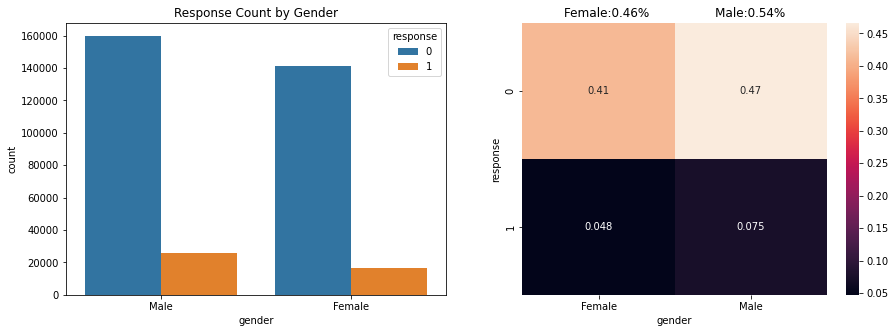

In [81]:
# count plot
fig, axs = plt.subplots(ncols=2, figsize = (15,5))
sns.countplot(x='gender', hue='response', data=df4, ax=axs[0]).set_title('Response Count by Gender')

# heatmap
aux = pd.crosstab(index=df4['response'], columns=df4['gender'], normalize=True)
sns.heatmap(aux, annot=True, ax=axs[1]).set_title(f'Female:{g_f:.2f}%                 Male:{g_m:.2f}%');

### 6.1.2. Age

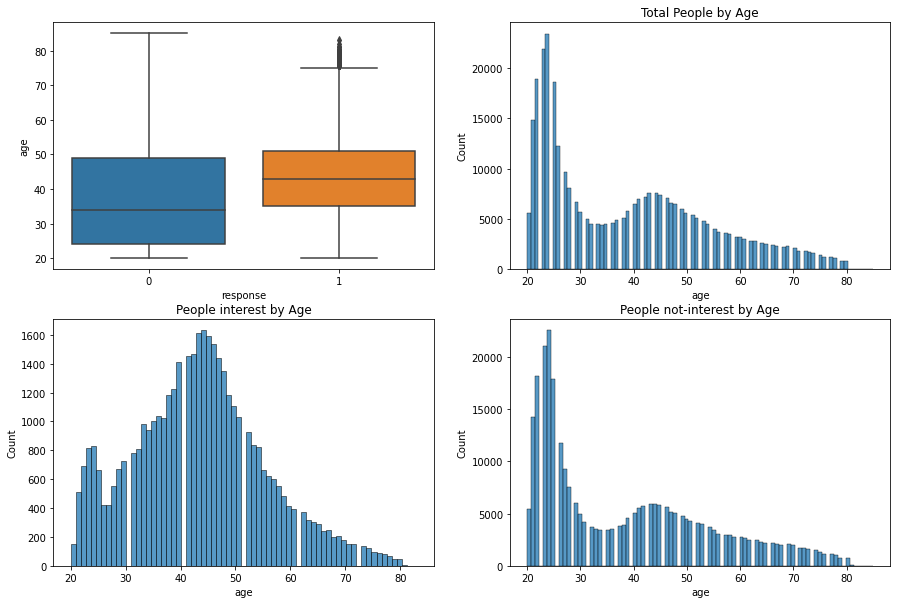

In [82]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# distribution of age
sns.histplot(x='age', data=df4, ax=axs[0,1]).set_title('Total People by Age');

# boxplot of age
sns.boxplot(x='response', y='age', data=df4, ax=axs[0,0]);

# distribution of interest people
aux1 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux1, ax=axs[1,0]).set_title('People interest by Age');

# distribution of no-interest people
aux = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux, ax=axs[1,1]).set_title('People not-interest by Age');

### 6.1.3. Region Code

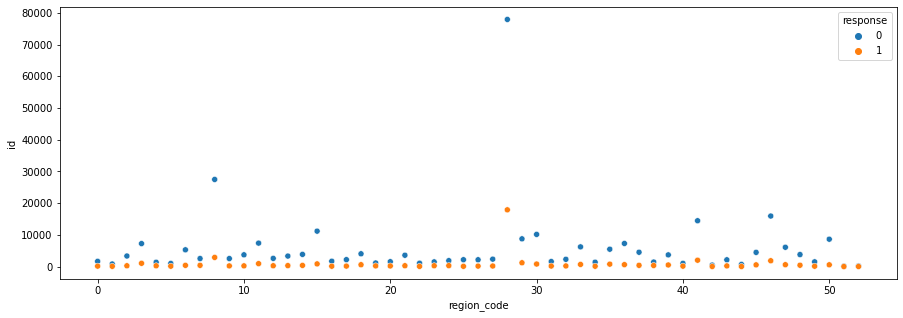

In [83]:
# number of id's in each region code
plt.subplots(figsize=(15, 5))
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux);

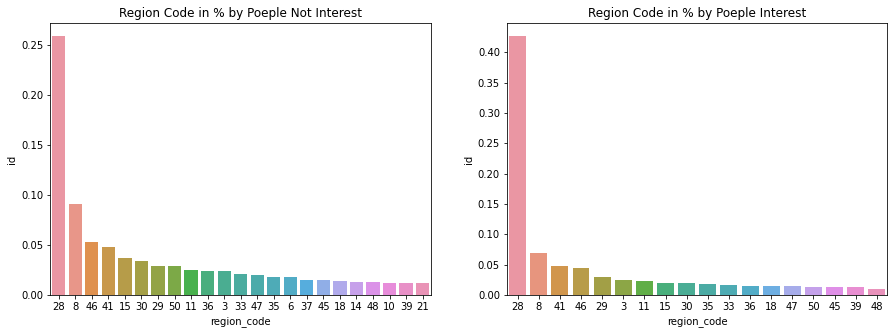

In [84]:
# define grid
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

# apply filters
aux1 = df4[df4['response'] == 0]
aux2 = df4[df4['response'] == 1]

# region code for people not interest
aux3 = aux1[['id', 'region_code']].groupby('region_code').count().reset_index().sort_values('id', ascending=False)
aux3['id'] = aux3['id'] / aux3['id'].sum()
aux3 = aux3.head(23)
sns.barplot(x='region_code', 
            y='id', data=aux3, 
            order=[28, 8, 46, 41, 15, 30, 29, 50, 11, 36, 3, 33, 47, 35, 6, 37, 45, 18, 14, 48, 10, 39, 21],
            ax=axs[0]).set_title('Region Code in % by Poeple Not Interest');

# region code for people interest
aux4 = aux2[['id', 'region_code']].groupby('region_code').count().reset_index().sort_values('id', ascending=False)
aux4['id'] = aux4['id'] / aux4['id'].sum()
aux4 = aux4.head(18)
sns.barplot(x='region_code', 
            y='id', data=aux4, 
            order=[28, 8, 41, 46, 29, 3, 11, 15, 30, 35, 33, 36, 18, 47, 50, 45, 39, 48],
            ax=axs[1]).set_title('Region Code in % by Poeple Interest');

### 6.1.4. Policy Sales Channel

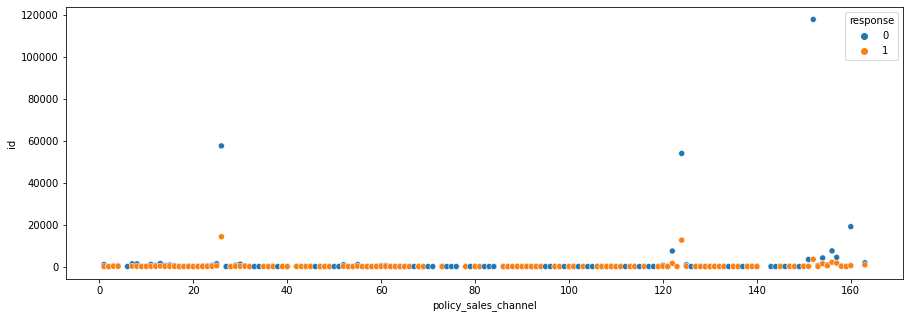

In [85]:
# number od id's in each sales channel
plt.subplots(figsize=(15, 5))
aux = df4[['id', 'policy_sales_channel', 'response']].groupby(['policy_sales_channel', 'response']).count().reset_index()
sns.scatterplot(x='policy_sales_channel', y='id', hue='response', data=aux);

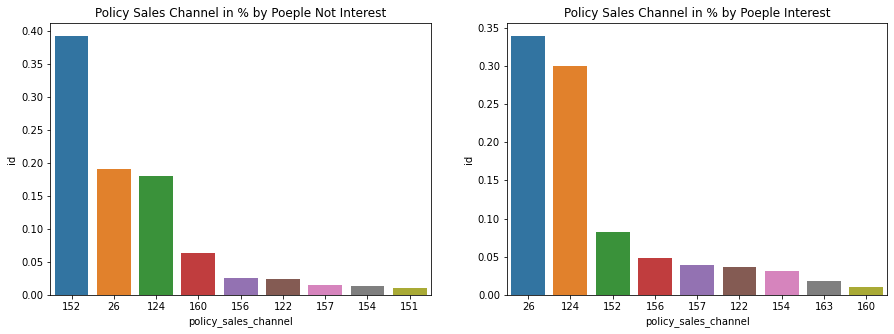

In [86]:
# define grid
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

# Separate interest/not-interest into datasets
aux2 = df4[df4['response'] == 0]
aux1 = df4[df4['response'] == 1]

# polycy salles channel for people not interest
aux4 = aux2[['id', 'policy_sales_channel']].groupby('policy_sales_channel').count().reset_index().sort_values('id', ascending=False)
aux4['id'] = aux4['id'] / aux4['id'].sum()
aux4 = aux4.head(9)
sns.barplot(x='policy_sales_channel', 
            y='id', data=aux4, 
            order=[152, 26, 124, 160, 156, 122, 157, 154, 151], 
            ax=axs[0]).set_title('Policy Sales Channel in % by Poeple Not Interest');

# polycy salles channel for people interest
aux3 = aux1[['id', 'policy_sales_channel']].groupby('policy_sales_channel').count().reset_index().sort_values('id', ascending=False)
aux3['id'] = aux3['id'] / aux3['id'].sum()
aux3 = aux3.head(9)
sns.barplot(x='policy_sales_channel', 
            y='id', 
            data=aux3, 
            order=[26, 124, 152, 156, 157, 122, 154, 163, 160], 
            ax=axs[1]).set_title('Policy Sales Channel in % by Poeple Interest');

### 6.1.5. Driving License

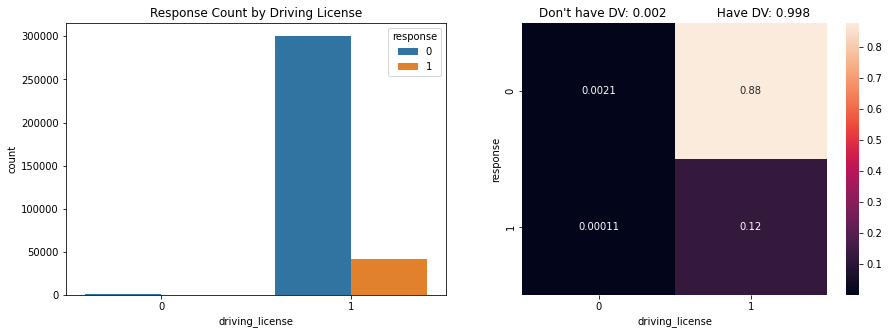

In [87]:
# define grid
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

# count  plot
sns.countplot(x='driving_license', hue='response', data=df4, ax=axs[0]).set_title('Response Count by Driving License')

# heat map
dv_0, dv_1 = len(df4[df4['driving_license'] == 0]) / len(df4), len(df4[df4['driving_license'] == 1]) / len(df4)
aux = pd.crosstab(index=df4['response'], columns=df4['driving_license'], normalize=True)
sns.heatmap(aux, annot=True, ax=axs[1]).set_title(f"Don't have DV: {dv_0:.3f}             Have DV: {dv_1:.3f}");

### 6.1.6. Vehicle Age

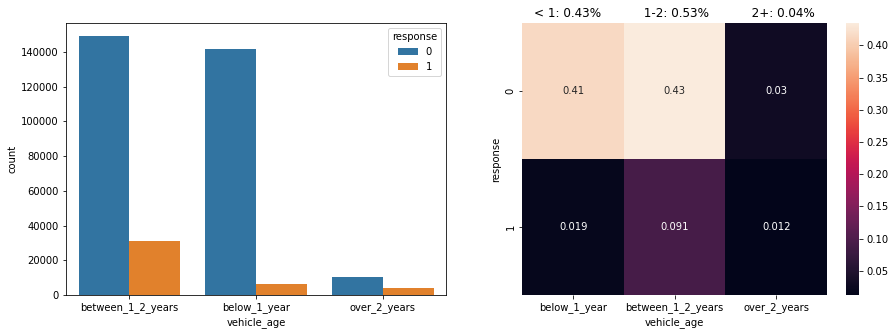

In [88]:
# define grid
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

# count plot
sns.countplot(x='vehicle_age', hue='response', data=df4, ax=axs[0]);

# heatmap
ve_1 = len(df4[df4['vehicle_age'] == 'below_1_year']) / len(df4)
ve_2 = len(df4[df4['vehicle_age'] == 'between_1_2_years']) / len(df4)
ve_3 = len(df4[df4['vehicle_age'] == 'over_2_years']) / len(df4)
aux = pd.crosstab(index=df4['response'], columns=df4['vehicle_age'], normalize=True)
sns.heatmap(aux, annot=True, ax=axs[1]).set_title(f"< 1: {ve_1:.2f}%           1-2: {ve_2:.2f}%           2+: {ve_3:.2f}%");

### 6.1.7. Vehicle Damage

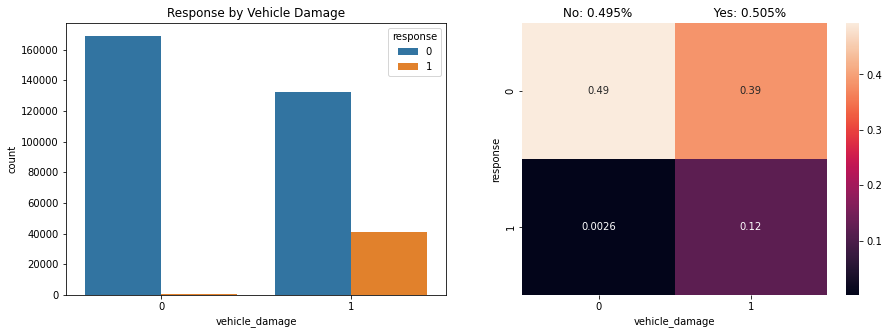

In [89]:
# define grid
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

# count plot
sns.countplot(x='vehicle_damage', hue='response', data=df4, ax=axs[0]).set_title('Response by Vehicle Damage');
              
# heatmap
vd_0, vd_1 = len(df4[df4['vehicle_damage'] == 0]) / len(df4), len(df4[df4['vehicle_damage'] == 1]) / len(df4)
aux = pd.crosstab(df4['response'], df4['vehicle_damage'], normalize=True)
sns.heatmap(aux, annot=True, ax=axs[1]).set_title(f"No: {vd_0:.3f}%                     Yes: {vd_1:.3f}%"); 

### 6.1.8. Previously Insured

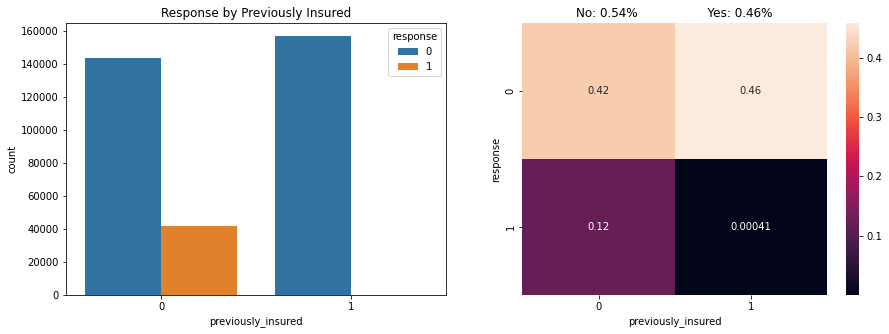

In [90]:
# define grid
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

# count plot
sns.countplot(x='previously_insured', hue='response', data=df4, ax=axs[0]).set_title('Response by Previously Insured');

# heatmap
pi_0, pi_1 = len(df4[df4['previously_insured'] == 0]) / len(df4), len(df4[df4['previously_insured'] == 1]) / len(df4)
aux = pd.crosstab(df4['response'], df4['previously_insured'], normalize=True)
sns.heatmap(aux, annot=True, ax=axs[1]).set_title(f"No: {pi_0:.2f}%                  Yes: {pi_1:.2f}%"); 

### 6.1.9. Annual Premium

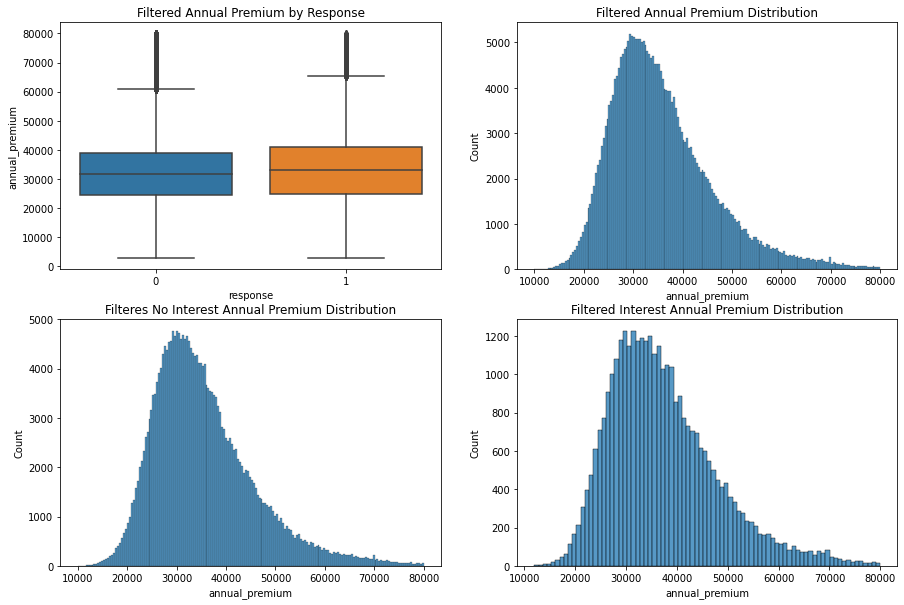

In [91]:
# define grid
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

# boxplot 
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux, ax=axs[0, 0]).set_title('Filtered Annual Premium by Response');

# filter dataset to plot distributions
aux = aux[aux['annual_premium'] > 10000][['annual_premium', 'response']]

# distibution both interests
aux1 = aux.loc[:, 'annual_premium']
sns.histplot(aux1, ax=axs[0, 1]).set_title('Filtered Annual Premium Distribution')

# distribution no interest
aux1 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux1, ax=axs[1, 0]).set_title('Filteres No Interest Annual Premium Distribution');

# distribution interest
aux2 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux2, ax=axs[1, 1]).set_title('Filtered Interest Annual Premium Distribution');

In [92]:
print(f'{len(df4[(df4["annual_premium"] < 10000) & (df4["response"] == 1)]) / len(df4[df4["response"] == 1]) * 100:.2f}% dos interessados ganham um bônus anual de $ 2630.00')
print(f'{len(df4[(df4["annual_premium"] > 80000) & (df4["response"] == 1)]) / len(df4[df4["response"] == 1]) * 100:.2f}% dos interessados ganham um bônus anual maior que $ 80.000')

18.11% dos interessados ganham um bônus anual de $ 2630.00
0.79% dos interessados ganham um bônus anual maior que $ 80.000


### 6.1.10. Vintage

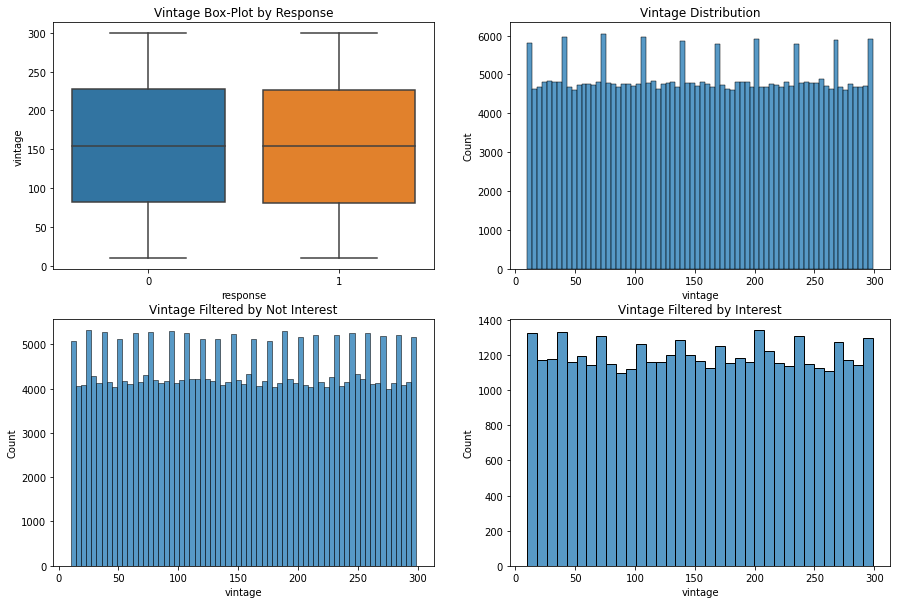

In [93]:
# define grid
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))  

# box plot vintage
sns.boxplot(x='response', y='vintage', data=df4, ax=axs[0,0]).set_title('Vintage Box-Plot by Response');

# vintage distribution
aux1 = df4.loc[:, 'vintage']
sns.histplot(aux1, ax=axs[0,1]).set_title('Vintage Distribution');

# vintage distribution by not interested
aux2 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux2, ax=axs[1,0]).set_title('Vintage Filtered by Not Interest');

# vintage distribution by interested
aux3 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux3, ax=axs[1,1]).set_title('Vintage Filtered by Interest');

### 6.1.11. Response

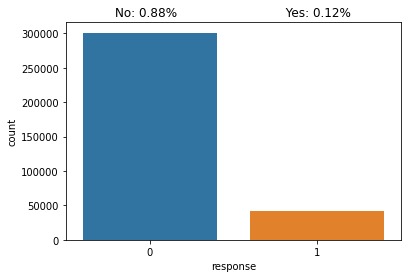

In [94]:
# percentage of interest
r_0, r_1 = len(df4[df4['response'] == 0]) / len(df4), len(df4[df4['response'] == 1]) / len(df4)
sns.countplot(x=df4['response']).set_title(f"No: {r_0:.2f}%                            Yes: {r_1:.2f}%");

### 6.1.12. Features that will possibly be useful for the ML model

In [95]:
# table with the conclusion of the bivariate analysis and the observed relevance of each hypothesis
tab = [['Feature', 'Relevance'],
       ['Gender', 'Low'],
       ['Age', 'Medium'],
       ['Region Code', 'Medium'],
       ['Policy Sales Channel', 'Medium'],
       ['Driving License', 'Low'],
       ['Vehicle Age', 'Medium'],
       ['Vehicle Damage', 'Medium'],
       ['Previously Insured', 'Medium'],
       ['Annual Premium', 'Low'],
       ['Vintage', 'Low']]

print(tabulate(tab, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════════╤═════════════╕
│ Feature              │ Relevance   │
╞══════════════════════╪═════════════╡
│ Gender               │ Low         │
├──────────────────────┼─────────────┤
│ Age                  │ Medium      │
├──────────────────────┼─────────────┤
│ Region Code          │ Medium      │
├──────────────────────┼─────────────┤
│ Policy Sales Channel │ Medium      │
├──────────────────────┼─────────────┤
│ Driving License      │ Low         │
├──────────────────────┼─────────────┤
│ Vehicle Age          │ Medium      │
├──────────────────────┼─────────────┤
│ Vehicle Damage       │ Medium      │
├──────────────────────┼─────────────┤
│ Previously Insured   │ Medium      │
├──────────────────────┼─────────────┤
│ Annual Premium       │ Low         │
├──────────────────────┼─────────────┤
│ Vintage              │ Low         │
╘══════════════════════╧═════════════╛


## 6.2. Bivariate Analysis

### 6.2.1. H01 - [True] Customers who have a driver's license correspond to 95% of those interested in vehicle insurance

**Actually, customers who have driver's license correspond to 99.91% of those interested in vehicle insurance.**

Percentage of customers with a driving license in the dataset: 99.78%


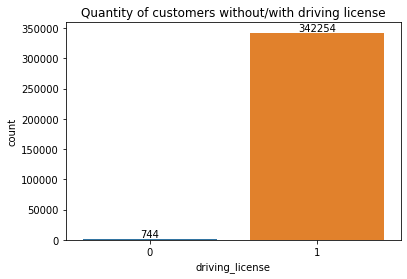

In [96]:
# Quantity of customers with/without driving license in the dataset 
aux = sns.countplot(df4['driving_license'])
aux.bar_label(aux.containers[0])
aux.set_title('Quantity of customers without/with driving license');

# percentage of customers with a driving license in the dataset
print(f'Percentage of customers with a driving license in the dataset: {342254 * 100 / (744 + 342254):.2f}%')

Percentage of customers with driver's license that is interested in vehicle insurance: 99.91%


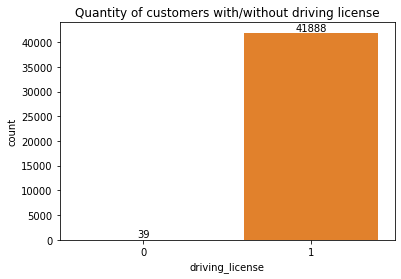

In [97]:
# filter only customers interested and return the driving license column
aux1 = df4.loc[df4['response'] == 1, 'driving_license']

# bar chart with the quantity of customers with/without driving license
aux2 = sns.countplot(aux1)
aux2.bar_label(aux2.containers[0]);
aux2.set_title('Quantity of customers with/without driving license');

# calculate de percentage of customers with driver's license that is interested in vehicle insurance
print(f"Percentage of customers with driver's license that is interested in vehicle insurance: {41888 * 100 / (41888 + 39):.2f}%")

### 6.2.2. H02 - [False] Female customers are more interested in vehicle insurance

**Female customers represents 45.94% of the dataset and the percentage of female who are interested in vehicle insurance is 10.36%, while the percentage of man is 13.81%**

Percentage of female customers in the dataset: 45.94%
Percentage of male customers in the dataset: 54.06%


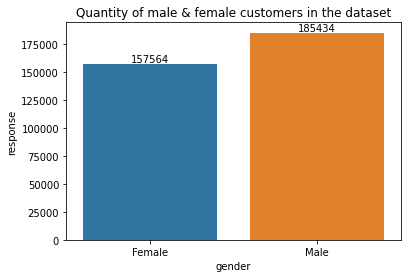

In [98]:
# quantity of male & female customers in the dataset
aux = df4[['gender', 'response']].groupby('gender').count().reset_index()

# bar chart with the quantity of male & female customers in the dataset
aux1 = sns.barplot(x='gender', y='response', data=aux)
aux1.bar_label(aux1.containers[0]);
aux1.set_title('Quantity of male & female customers in the dataset');

# percentage of female customers in the dataset
print(f'Percentage of female customers in the dataset: {157564 * 100 / (157564 + 185434):.2f}%')
print(f'Percentage of male customers in the dataset: {100 - (157564 * 100 / (157564 + 185434)):.2f}%')

Percentage of female customers who are interested: 10.36%
Percentage of male customers who are interested: 13.81%


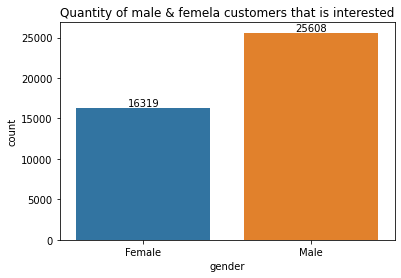

In [99]:
# filter only customers interested and return the gender column
aux2 = df4.loc[df4['response'] == 1, 'gender']

# bar chart with the quantity of male & female customers that  is interested
aux3 = sns.countplot(aux2)
aux3.bar_label(aux3.containers[0]);
aux3.set_title('Quantity of male & femela customers that is interested');

# percentage of male & female customers who are interested
print(f'Percentage of female customers who are interested: {16319*100 / 157564:.2f}%')
print(f'Percentage of male customers who are interested: {25608*100 / 185434:.2f}%')

### 6.2.3. H03 - [True] Customers over 60 years old are the least interested in vehicle insurance

**Customers over 60 years old represents 12.25% of the dataset and the percentage of 60+ who are interested in vehicle insurance is 9.88%, while the percentage of customers until 59 years old is 12.55%**

Percentage of customers with 60+ years old in the dataset: 12.25%


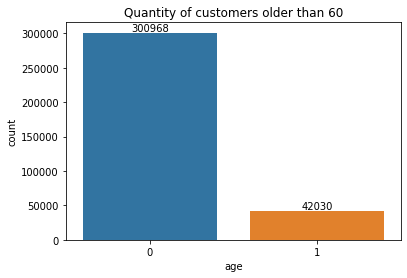

In [100]:
# auxiliar columns with customers older than 60
aux = df4['age'].apply(lambda x: 1 if x >= 60 else 0)

# bar chart with the quantity of customers older than 60
aux1 = sns.countplot(aux)
aux1.bar_label(aux1.containers[0]);
aux1.set_title('Quantity of customers older than 60');

# percentage of customers older than 60 in the dataset
print(f'Percentage of customers with 60+ years old in the dataset: {42030 * 100 / (300968 + 42030):.2f}%')

Percentage of customers with 60+ years old that is interested: 9.88%
Percentage of customers until 59 years old that is interested: 12.55%


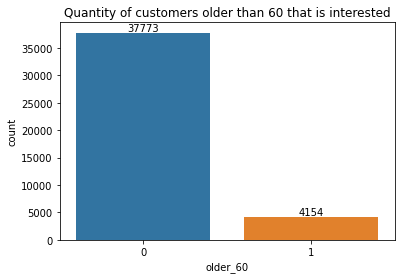

In [101]:
# filter only customers interested and return the age column
aux3 = pd.DataFrame(df4.loc[df4['response'] == 1, 'age'])

# auxiliar columns with customers older than 60
aux3['older_60'] = aux3['age'].apply(lambda x: 1 if x >= 60 else 0)

# bar chart with the quantity of customers with 60+ years old that is interested
aux4 = sns.countplot(aux3['older_60']);
aux4.bar_label(aux4.containers[0])
aux4.set_title('Quantity of customers older than 60 that is interested');

# percentage of customers with 60+ years old that is interested
print(f'Percentage of customers with 60+ years old that is interested: {4154 * 100 / 42030:.2f}%')
print(f'Percentage of customers until 59 years old that is interested: {37773 * 100 / 300968:.2f}%')

### 6.2.4. H04 - [True] Customers between 27 and 59 years old are most interested in vehicle insurance

**Customers between 27 and 59 years old represents 54.14% of the dataset and the percentage of those who are interested in vehicle insurance is 18.14%, while the percentage of customers out of this range of age is 5.24%**

Percentage of customers beetwen 27 and 59 years old in the dataset: 54.14%


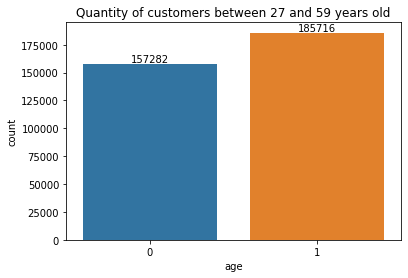

In [102]:
# quantity of customers beetwen 27 and 59  years old in the dataset
aux = df4['age'].apply(lambda x: 1 if (x >= 27) & (x <= 59) else 0)

# bar chart with the quantity of customers between 27 and 59 years old in the dataset
aux1 = sns.countplot(aux)
aux1.bar_label(aux1.containers[0]);
aux1.set_title('Quantity of customers between 27 and 59 years old');

# percentage of customers beetwen 27 and 59  years old in the dataset
print(f'Percentage of customers beetwen 27 and 59 years old in the dataset: {185716 * 100 / (157282 + 185716):.2f}%')

Percentage of customers between 27 and 59 years old that is interested: 18.14%
Percentage of customers until 26 years old and after 59 years old that is interested: 5.24%


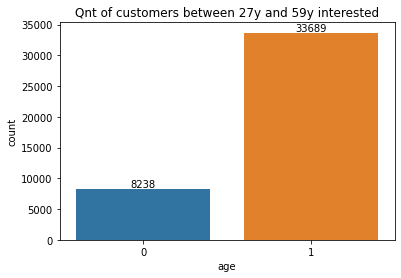

In [103]:
# filter only customers interested and return the age column
aux2 = pd.DataFrame(df4.loc[df4['response'] == 1, 'age'])

# create a auxiliar column with the customers between 27 and 59 years old
aux3 = aux2['age'].apply(lambda x: 1 if (x >= 27) & (x <= 59) else 0)

# plot a bar chart comparing the quantity of customers between 27 and 59 years old and the others outside of the range
aux4 = sns.countplot(aux3)
aux4.bar_label(aux4.containers[0])
aux4.set_title('Qnt of customers between 27y and 59y interested');

# percentage of customers between 27 and 59 years old that is interested
print(f'Percentage of customers between 27 and 59 years old that is interested: {33689 * 100 / 185716:.2f}%')
print(f'Percentage of customers until 26 years old and after 59 years old that is interested: {8238 * 100 / 157282:.2f}%')

### 6.2.5. H05 - [True] Customers who already have vehicle insurance correspond to less than 10% of those interested

**Actually, customers who already owns a vehicle insurance correspond to 0.33% of those interested**

Percentage of customers that already have a insurance: 45.84%


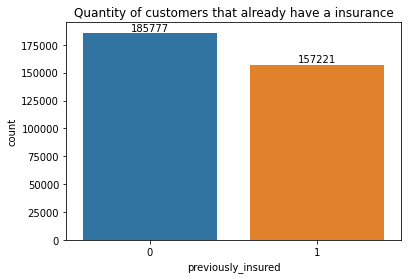

In [104]:
# Quantity of customers in the dataset that already have a insurance
aux = sns.countplot(df4['previously_insured'])
aux.bar_label(aux.containers[0])
aux.set_title('Quantity of customers that already have a insurance');

# percentage of customers that already have a insurance
print(f'Percentage of customers that already have a insurance: {157221 * 100 / (185777 + 157221):.2f}%')

Percentage of interested customers that already have a insurance: 0.33%


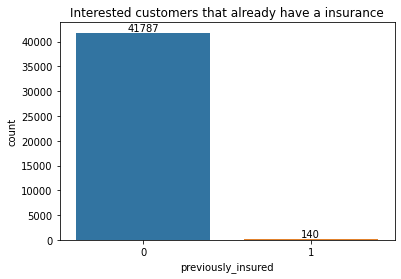

In [105]:
# filter only customers interested and return the previously_insured column
aux1 = df4.loc[df4['response'] == 1, 'previously_insured']

# plot a bar chart with the quantity of interested customers that already have a insurance
aux2 = sns.countplot(aux1)
aux2.bar_label(aux2.containers[0])
aux2.set_title('Interested customers that already have a insurance');

# percentage of interested customers that already have a insurance 
print(f'Percentage of interested customers that already have a insurance: {140 * 100 / (41787 + 140):.2f}%')

### 6.2.6. H06 - [-] Customers who are in the base for a period longer than the average are more interested in vehicle insurance

**The difference between interested customers who are in the base for a period greater than the vintage average is insignificant, so the hypothesis can't be validated or invalidated**

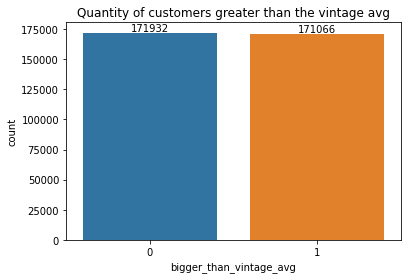

In [106]:
# filter only vintage and response columns
aux = df4[['vintage', 'response']]

# find the vintage's average
avg_vintage = round(df4['vintage'].mean())

# create a auxiliar column with customer's vintage bigger/smaller than the average(154) 
aux['bigger_than_vintage_avg'] = aux['vintage'].apply(lambda x: 1 if x > avg_vintage else 0)

# Quantity of customers greater than the vintage average
aux2 = sns.countplot(aux['bigger_than_vintage_avg'])
aux2.bar_label(aux2.containers[0])
aux2.set_title('Quantity of customers greater than the vintage avg');

Percentage of interested customers bigger than the vintage average: 49.81%


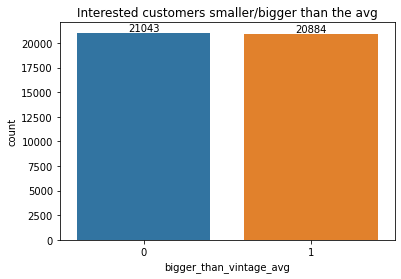

In [107]:
# filter only interested customers and return the vintage
aux2 = aux.loc[aux['response'] == 1, 'bigger_than_vintage_avg']

# plot bar chart with quantity of interested customers bigger and smaller than the vintage average
aux3 = sns.countplot(aux2)
aux3.bar_label(aux3.containers[0])
aux3.set_title('Interested customers smaller/bigger than the avg')

# percentage of interested customers bigger than the vintage average
print(f'Percentage of interested customers bigger than the vintage average: {20884 * 100 / (21043 + 20884):.2f}%')

### 6.2.7. H07 - [True] Customers who own cars up to 2 years old correspond to more than 80% of those interested

**Customers who own cars up to 2 years old represents 89.88% of those interested**

Percentage of customers with cars up to 2 years old: 95.78%


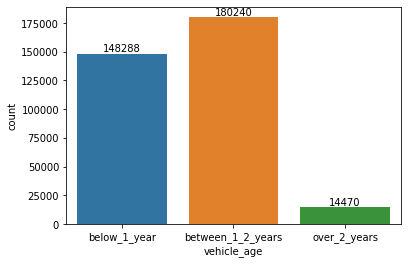

In [108]:
# Quantity of customers in the dataset that have the car age between the three options
aux = sns.countplot(df4['vehicle_age'], order=['below_1_year', 'between_1_2_years', 'over_2_years'])
for container in aux.containers:
    aux.bar_label(container)

# Percentage of customers with cars up to 2 years old
print(f'Percentage of customers with cars up to 2 years old: {(148288 + 180240) * 100 / len(df4):.2f}%')

Percentage of interested customers with vehicle up to 2 years old: 89.88%


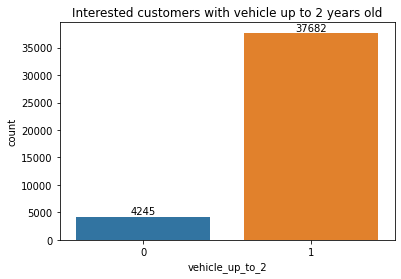

In [109]:
# filter only interested customers and return the vehicle_age column
aux1 = pd.DataFrame(df4.loc[df4['response'] == 1, 'vehicle_age'])

# create a new column with cars up to 2 years 
aux1['vehicle_up_to_2'] = aux1['vehicle_age'].apply(lambda x: 1 if (x == 'below_1_year') | (x == 'between_1_2_years') else 0)

# plot a count plot to visualize
aux2 = sns.countplot(aux1['vehicle_up_to_2'])
aux2.bar_label(aux2.containers[0])
aux2.set_title('Interested customers with vehicle up to 2 years old');

# Percentage of interested customers with vehicle up to 2 years old
print(f'Percentage of interested customers with vehicle up to 2 years old: {37682 * 100 / (4245 + 37682):.2f}%')

### 6.2.8. H08 - [True] Customers who had their car crashed correspond to more than 90% of those interested in vehicle insurance

**Customers who already had their car crashed correspond to 97.90% of those interested**

Percentage of customers in the dataset that had their car crashed: 50.49%


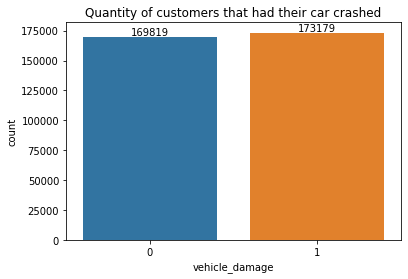

In [110]:
# Quantity of customers in the dataset that had their car crashed
aux = sns.countplot(df4['vehicle_damage'])
aux.bar_label(aux.containers[0])
aux.set_title('Quantity of customers that had their car crashed');

# percentage of customers in the dataset that had their car crashed
print(f'Percentage of customers in the dataset that had their car crashed: {173179 * 100 / len(df4):.2f}%')

Percentage of interested customers that already had their car crashed: 97.90%


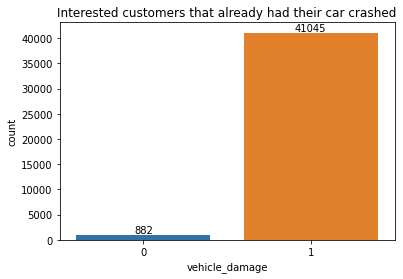

In [111]:
# filter only customers interested and return the vehicle_damage column
aux1 = df4.loc[df4['response'] == 1, 'vehicle_damage']

# plot a bar chart with the quantity of interested customers that already had their car crashed
aux2 = sns.countplot(aux1)
aux2.bar_label(aux2.containers[0])
aux2.set_title('Interested customers that already had their car crashed');

# percentage of interested customers that already had their car crashed
print(f'Percentage of interested customers that already had their car crashed: {41045 * 100 / len(aux1):.2f}%')

### 6.2.9. H09 - [False] Customers whose premium paid annually is below average are more interested in car insurance

**Actually, customers whose premium paid annually is below average are less interested in vehicle insurance, they corresponds to 41.52% of those interested**

Percentage of customers in the dataset that had the annual premium smaller then the average: 45.76%


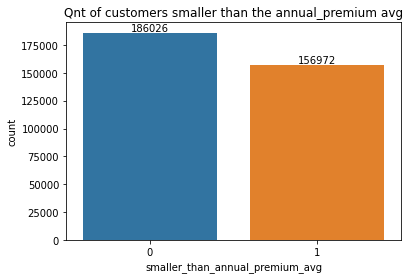

In [112]:
# filter only annual_premium and response columns
aux = df4[['annual_premium', 'response']]

# find the annual_premium's average
avg_annual_premium = round(df4['annual_premium'].mean())

# create a auxiliar column with customer's annual_premium smaller/bigger than the average 
aux['smaller_than_annual_premium_avg'] = aux['annual_premium'].apply(lambda x: 1 if x < avg_annual_premium else 0)

# Quantity of customers smaller than the annual_premium average
aux1 = sns.countplot(aux['smaller_than_annual_premium_avg'])
aux1.bar_label(aux1.containers[0])
aux1.set_title('Qnt of customers smaller than the annual_premium avg');

# percentage of customers in the dataset that had the annual premium smaller then the average
print(f'Percentage of customers in the dataset that had the annual premium smaller then the average: {156972 * 100 / len(df4):.2f}%')

Percentage of interested customers smaller than the annual premium average: 41.52%


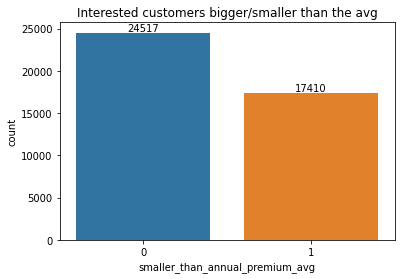

In [113]:
# filter only interested customers and return the annual_premium column
aux2 = aux.loc[aux['response'] == 1, 'smaller_than_annual_premium_avg']

# plot bar chart with quantity of interested customers bigger and smaller than the annual premium average
aux3 = sns.countplot(aux2)
aux3.bar_label(aux3.containers[0])
aux3.set_title('Interested customers bigger/smaller than the avg')

# percentage of interested customers smaller than the annual premium average
print(f'Percentage of interested customers smaller than the annual premium average: {17410 * 100 / len(aux2):.2f}%')

### 6.2.10. H10 - [True] 20% of marketing channels correspond to +80% of interested parties

**Actually, 20% of marketing channels correspond to 97.75% of interested customers**

In [114]:
# quantity of interested customers
print(f"Quantity of interested customers: {len(df4[df4['response'] == 1])}")

# quantity of sales channel
print(f"Quantity of sales channel: {len(df4['policy_sales_channel'].unique())}")

# 20% of the total sales channel
print(f'20% of 154: {154 * 0.2}')

# filter only interested customers, count the id's of each sales channel and sort descending
aux = df4.loc[df4['response'] == 1]
aux1 = aux[['id', 'policy_sales_channel']].groupby('policy_sales_channel').count().reset_index().sort_values('id', ascending=False)

# percentage of interested customers in 20% of sales channels
print(f"20% of marketing sales channel corresponds to {40985 * 100 / 41927:.2f}% ({aux1.head(30)['id'].sum()}) of interested customers.")

Quantity of interested customers: 41927
Quantity of sales channel: 154
20% of 154: 30.8
20% of marketing sales channel corresponds to 97.75% (40985) of interested customers.


In [115]:
# 30 sales channel with the biggest quantity of interested customers
aux2 = df4.loc[df4['response'] == 1, 'policy_sales_channel'].value_counts().sort_values(ascending=False).head(30)
aux2

26     14216
124    12596
152     3469
156     2048
157     1623
122     1544
154     1326
163      784
160      423
155      352
25       330
13       253
55       171
7        167
3        149
31       138
30       134
125      122
12       119
158      117
151      116
8        114
52       103
11        98
29        94
24        94
4         91
150       69
15        69
120       56
Name: policy_sales_channel, dtype: int64

### 6.2.11. Summary of Hypotheses 

In [116]:
# table with the conclusion of the bivariate analysis and the observed relevance of each hypothesis
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H01', 'True', 'Low'],
       ['H02', 'False', 'Medium'],
       ['H03', 'True', 'Medium'],
       ['H04', 'True', 'Medium'],
       ['H05', 'True', 'Medium'],
       ['H06', 'NA', 'Low'],
       ['H07', 'True', 'High'],
       ['H08', 'True', 'High'],
       ['H09', 'False', 'Medium'],
       ['H10', 'True', 'High']]

print(tabulate(tab, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════╤══════════════╤═════════════╕
│ Hypothesis   │ Conclusion   │ Relevance   │
╞══════════════╪══════════════╪═════════════╡
│ H01          │ True         │ Low         │
├──────────────┼──────────────┼─────────────┤
│ H02          │ False        │ Medium      │
├──────────────┼──────────────┼─────────────┤
│ H03          │ True         │ Medium      │
├──────────────┼──────────────┼─────────────┤
│ H04          │ True         │ Medium      │
├──────────────┼──────────────┼─────────────┤
│ H05          │ True         │ Medium      │
├──────────────┼──────────────┼─────────────┤
│ H06          │ NA           │ Low         │
├──────────────┼──────────────┼─────────────┤
│ H07          │ True         │ High        │
├──────────────┼──────────────┼─────────────┤
│ H08          │ True         │ High        │
├──────────────┼──────────────┼─────────────┤
│ H09          │ False        │ Medium      │
├──────────────┼──────────────┼─────────────┤
│ H10          │ True         │ Hi

### 6.2.12. Possible Actions - Insights

- Prioritize the offer for customers who are between 27 and 59 years old
- Prioritize the offer for customers who currently do not have vehicle insurance 
- Develop more attractive insurance offers for customers who own cars with up to 2 years since manufacture
- Analyze ways to get customers who have already had their car crashed 
- Target offers to customers who pay over $30,000 a year on health insurance
- Intensify marketing in sales channels: 26, 124, 152, 156

## 6.3. Multivariate Analysis

### 6.3.1. Numerical Features

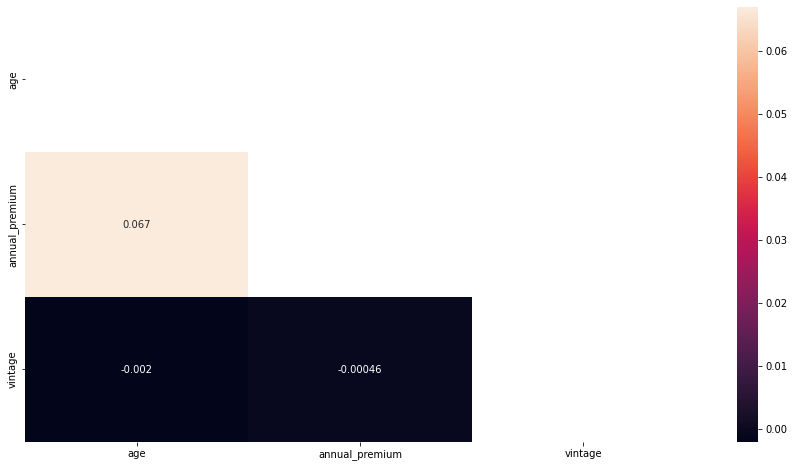

In [117]:
# selected numerical features
num_features = df4[['age', 'annual_premium', 'vintage']]

# calc correlation
correlation = num_features.corr(method='pearson')

# create a mask
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# plot heatmap
plt.subplots(figsize=(15, 8))
sns.heatmap(correlation, annot=True, mask=mask);

### 6.3.2. Categorical Features

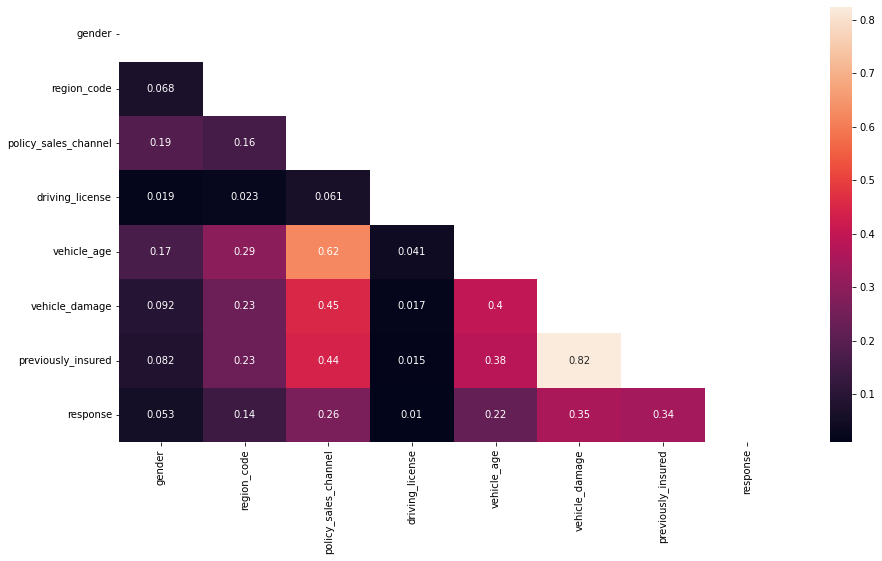

In [118]:
# selected categorical features
cat_features = df4[['gender', 'region_code', 'policy_sales_channel', 'driving_license', 'vehicle_age', 'vehicle_damage', 'previously_insured', 'response']]

# dataframe with cramer-v 
cramer_v_dataframe = cramers_v_df(cat_features)

# create a mask
mask = np.zeros_like(cramer_v_dataframe, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# display heatmap
plt.subplots(figsize=(15, 8))
sns.heatmap( cramer_v_dataframe, annot = True, mask=mask);

# <font color='darkblue'> 7.0. Data Preparation </font>

In [123]:
# # save pickle
# pickle.dump(df4, open('../src/steps/df5_aux.pkl', 'wb'))

# load pickle
df5_aux = pickle.load(open('../src/steps/df5_aux.pkl', 'rb'))

In [124]:
# create X and y
X = df5_aux.drop('response', axis=1)
y = df5_aux['response'].copy()

# split data into train and validation
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [125]:
# # concat the train dataset
df5 = pd.concat([x_train, y_train], axis=1)

# save pickle
pickle.dump(df5, open('../src/steps/df5.pkl', 'wb'))

In [126]:
# load pickle
df5 = pickle.load(open('../src/steps/df5.pkl', 'rb'))

**Standardization**: annual_premium

**Normalization**: age, vintage

**Encoding**: gender, vehicle_damage, region_code, policy_sales_channel

## 7.1. Feature Scaling 

### 7.1. Standardization

In [127]:
# # annual_premium
rs = RobustScaler()
df5['annual_premium'] = rs.fit_transform(df5[['annual_premium']].values)

# save pickle
pickle.dump(rs, open('../src/transformations/annual_premium_scaler.pkl', 'wb'))

### 7.1.2. Normalization

In [128]:
# # age
mms_age = MinMaxScaler()
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# save pickle
pickle.dump(mms_age, open('../src/transformations/age_scaler.pkl', 'wb'))

# # vintage
mms_vintage = MinMaxScaler()
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

# save pickle
pickle.dump(mms_vintage, open('../src/transformations/vintage_scaler.pkl', 'wb'))

## 7.2. Encoding

### 7.2.1. Label Encoding

In [129]:
# Gender
df5['gender'] = df5['gender'].apply(lambda x: 1 if x == 'Male' else 0)

### 7.2.2. Ordinal Encoding

In [130]:
# Vehicle Age
df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x: 0 if x == 'below_1_year' else
                                                        1 if x == 'between_1_2_years' else
                                                        2)

### 7.2.3. Frequency Encoding

In [131]:
# # Region Code
fe = df5.groupby('region_code').size() / len(df5)
df5['region_code'] = df5['region_code'].map(fe)

# save pickle
pickle.dump(fe, open('../src/transformations/region_code_encoder.pkl', 'wb'))

# # Policy Sales Channel
fe1 = df5.groupby('policy_sales_channel').size() / len(df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(fe1)

# save pickle
pickle.dump(fe1, open('../src/transformations/policy_sales_channel_encoder.pkl', 'wb'))

## 7.3. Validation Preparation

In [132]:
# stardardization
x_val['annual_premium']       = rs.transform(x_val[['annual_premium']].values)

# Rescaling
x_val['age']                  = mms_age.transform(x_val[['age']].values)

x_val['vintage']              = mms_vintage.transform(x_val[['vintage']].values)

# Encoders
x_val['gender']               = x_val['gender'].apply(lambda x: 1 if x == 'Male' else 0)

x_val['region_code']          = x_val['region_code'].map(fe)

x_val['policy_sales_channel'] = x_val['policy_sales_channel'].map(fe1)

x_val['vehicle_age']          = x_val['vehicle_age'].apply(lambda x: 0 if x == 'below_1_year' else
                                                                     1 if x == 'between_1_2_years' else
                                                                     2)

### 7.3.1. Check NAs

In [133]:
x_val.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    1
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
dtype: int64

Four missing values was created in x_val dataset at column policy_sales_channel, because the split don't put all unique values in the train dataset, but how it is just one missing values, i will fill by 0 and continuous the process.

In [134]:
x_val['policy_sales_channel'] = x_val['policy_sales_channel'].fillna(0)

# <font color='darkblue'> 8.0. Feature Selection </font>

In [136]:
# # save pickle
# pickle.dump(df5, open('../src/steps/df6.pkl', 'wb')) 

# load pickle
df6 = pickle.load(open('../src/steps/df6.pkl', 'rb'))

In [137]:
# create X and y for feature selection
x_train_fs = df6.drop(columns=['id', 'response'])
y_train_fs = df6['response']

## 8.1. Feature Importance - LightGBM

In [138]:
from sklearn.feature_selection import SelectFromModel

# model definition
lgbc=LGBMClassifier(n_estimators=200)

# data fitted
embeded_lgb_selector = SelectFromModel(lgbc)
embeded_lgb_selector.fit(np.array(x_train_fs), np.array(y_train_fs))

# feature importance evaluation
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = x_train_fs.loc[:,embeded_lgb_support].columns.tolist()

# show most important features
embeded_lgb_feature

['age', 'region_code', 'policy_sales_channel', 'annual_premium', 'vintage']

## 8.2. Feature Importance - Random Forest

In [139]:
# model definition
forest = RandomForestClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data fitted
forest.fit(np.array(x_train_fs), 
           np.array(y_train_fs))

RandomForestClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                feature  importance
0               vintage       0.280
0        annual_premium       0.251
0                   age       0.143
0           region_code       0.102
0        vehicle_damage       0.072
0  policy_sales_channel       0.069
0    previously_insured       0.050
0           vehicle_age       0.020
0                gender       0.013
0       driving_license       0.001


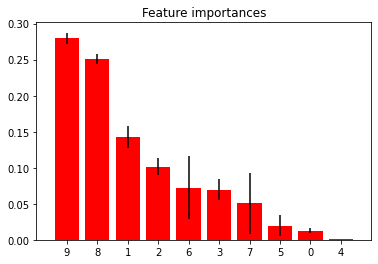

In [140]:
# Obtain importances
importances = forest.feature_importances_

# Calc importances's STD
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# Sort by the biggest importance
indices = np.argsort(importances)[::-1]

# Show features and their importances in a df
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(x_train_fs, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importancces of the forest
plt.figure()
plt.title('Feature importances')
plt.bar(range(x_train_fs.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_fs.shape[1]), indices)
plt.xlim([-1, x_train_fs.shape[1]])
plt.show()

## 8.3. Features Selected

In [141]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage',
                 'policy_sales_channel', 'previously_insured']

# <font color='darkblue'> 9.0. Machine Learning </font>

In [143]:
# # save pickle
# pickle.dump(x_val, open('../src/steps/df7.pkl', 'wb')) 

# load pickle
df7 = pickle.load(open('../src/steps/df7.pkl', 'rb'))

# Select train and validation dataset with only selected columns
x_train = df5[cols_selected]
x_validation = df7[cols_selected]

## 9.1. Algorithms

### 9.1.1. KNN

In [144]:
# model definition
knn_model = KNeighborsClassifier(n_neighbors=50) 

# model training
knn_model.fit(x_train, y_train) 

# model prediction
y_pred_knn = knn_model.predict_proba(x_validation) 

### 9.1.2. Naive Bayes

In [145]:
# model definition
nb_model = GaussianNB()

# model training
nb_model.fit(x_train, y_train)

# model prediction
y_pred_nb = nb_model.predict_proba(x_validation)

### 9.1.3. Logistic Regression

In [146]:
# model definition
lr_model = LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
y_pred_lr = lr_model.predict_proba(x_validation)

### 9.1.4. Random Forest 

In [147]:
# model definition
rf_model = RandomForestClassifier(n_jobs=-1,
                                  n_estimators=200,
                                  class_weight={0:1, 1:9.7})

# model training
rf_model.fit(x_train, y_train)

# model prediction
y_pred_rf = rf_model.predict_proba(x_validation)

### 9.1.5. XGBoost 

In [148]:
# model definition
xgb_model = XGBClassifier(objective='binary:logistic',
                          learning_rate=0.1,
                          reg_lambda=0,
                          gamma=0.5,
                          eval_metric='logloss',
                          use_label_encoder=False)

# model training
xgb_model.fit(x_train, y_train, verbose=True)

# model prediction
y_pred_xgb = xgb_model.predict_proba(x_validation)

### 9.1.6. LightGBM

In [149]:
# model definition
lgbm_model = LGBMClassifier(n_estimators=200)

# model training
lgbm_model.fit(x_train, y_train)

# model prediction
y_pred_lgbm = lgbm_model.predict_proba(x_validation)

### 9.1.7. CatBoost

In [150]:
# model definition
cb_model = CatBoostClassifier(loss_function='CrossEntropy', silent=True)

# model training
cb_model.fit(x_train, y_train)

# model prediction
y_pred_cb = cb_model.predict_proba(x_validation)

## 9.2. Metrics

### 9.2.1. Precision @K

In [143]:
# dataframe to save model's precision@k
precisionatk_df = pd.DataFrame(columns=['Model', 'Size_MB', 'Precision@k'])

# size of true values from target validation dataset
k_size = len(y_val[y_val == 1])

# List of model's predictions
y_preds_list = {'KNN': [y_pred_knn, knn_model], 
                'Logistic Regression': [y_pred_lr, lr_model], 
                'Naive Bayes': [y_pred_nb, nb_model],
                'Random Forest': [y_pred_rf, rf_model],
                'XGBoost': [y_pred_xgb, xgb_model],
                'LightGBM': [y_pred_lgbm, lgbm_model],
                'CatBoost': [y_pred_cb, cb_model]}

# add y_val to data to create score metrics 
df7['response'] = y_val.copy()

# populate df with precision@k and model's size
for k, v in y_preds_list.items():
    
    # propensity score
    df7['propensity_score'] = v[0][:, 1].tolist()
    
    # calc precision@k
    precisionatk = precision_at_k(df7, k=k_size)
    
    # calc trained model's size
    model_size = get_size(v[1])
    
    # populate dataframe
    precisionatk_df = precisionatk_df.append({'Model': k, 'Size_MB': model_size, 'Precision@k': precisionatk}, ignore_index=True)

#### 9.2.1.1. Precision @K - Cross Validation

In [448]:
# Run Cross-Validation in all models
y_pred_knn_cv, precision_at_k_knn_cv   = cross_validation(knn_model, 'KNN', x_train, y_train, 15)
y_pred_nb_cv, precision_at_k_nb_cv     = cross_validation(nb_model, 'Naive Bayes', x_train, y_train, 15)
y_pred_lr_cv, precision_at_k_lr_cv     = cross_validation(lr_model, 'Logistic Regression', x_train, y_train, 15)
y_pred_rf_cv, precision_at_k_rf_cv     = cross_validation(rf_model, 'Random Forest', x_train, y_train, 15)
y_pred_xgb_cv, precision_at_k_xgb      = cross_validation(xgb_model, 'XGBoost', x_train, y_train, 15)
y_pred_lgbm_cv, precision_at_k_lgbm_cv = cross_validation(lgbm_model, 'LightGBM', x_train, y_train, 15)
y_pred_cb_cv, precision_at_k_cb_cv     = cross_validation(cb_model, 'CatBoost', x_train, y_train, 15)

In [449]:
# df with model's precision @k - cv
precision_at_k_metrics = pd.concat([precision_at_k_knn_cv, precision_at_k_nb_cv, 
                                    precision_at_k_lr_cv, precision_at_k_rf_cv, 
                                    precision_at_k_xgb, precision_at_k_lgbm_cv, 
                                    precision_at_k_cb_cv])

#### 9.2.1.2. Compare 

In [450]:
# join precision @k without and with cross validation
model_results = pd.merge(precisionatk_df, precision_at_k_metrics, on='Model', how='left' )
model_results

,Model,Size_MB,Precision@k,Precision@k_CV,CV_STD
0,KNN,34.700,0.349,0.339,0.009
1,Logistic Regression,0.001,0.310,0.300,0.008
2,Naive Bayes,0.001,0.310,0.304,0.008
3,Random Forest,914.315,0.336,0.330,0.006
4,XGBoost,0.731,0.389,0.377,0.006
5,LightGBM,0.663,0.384,0.374,0.008
6,CatBoost,1.030,0.388,0.377,0.007


### 9.2.2. Gain Curve Plots

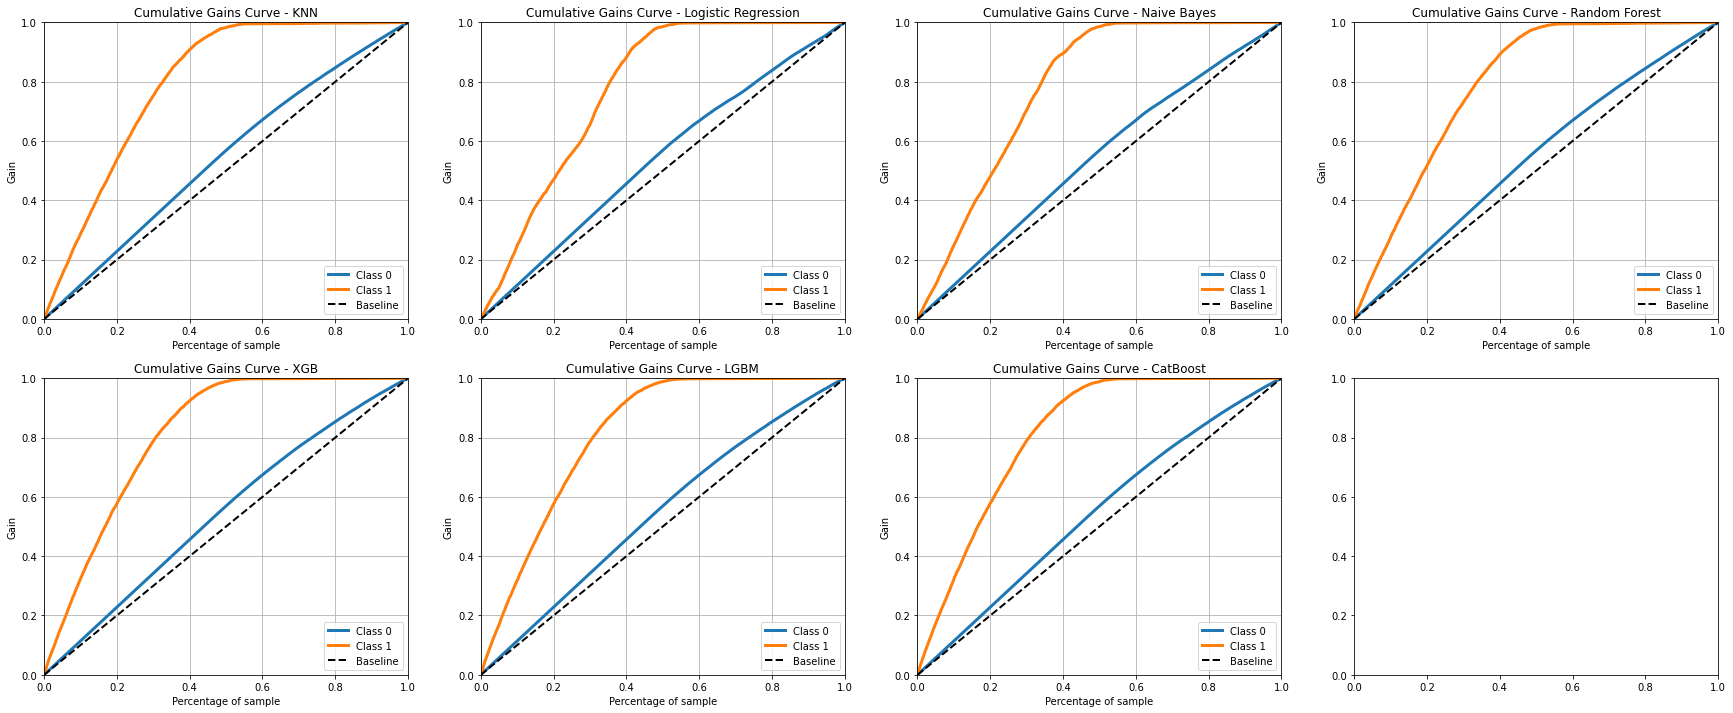

In [451]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(30, 12))

# KNN
skplt.metrics.plot_cumulative_gain(y_val, y_pred_knn, title='Cumulative Gains Curve - KNN', ax=axs[0,0]); 

# Logistic Regression
skplt.metrics.plot_cumulative_gain(y_val, y_pred_lr, title='Cumulative Gains Curve - Logistic Regression', ax=axs[0,1]);

# Naive Bayes
skplt.metrics.plot_cumulative_gain(y_val, y_pred_nb, title='Cumulative Gains Curve - Naive Bayes', ax=axs[0,2]); 

# Random Forest
skplt.metrics.plot_cumulative_gain(y_val, y_pred_rf, title='Cumulative Gains Curve - Random Forest', ax=axs[0,3]);

# XGBoost
skplt.metrics.plot_cumulative_gain(y_val, y_pred_xgb, title='Cumulative Gains Curve - XGB', ax=axs[1,0]);

# LGBM
skplt.metrics.plot_cumulative_gain(y_val, y_pred_lgbm, title='Cumulative Gains Curve - LGBM', ax=axs[1,1]);

# CatBoost
skplt.metrics.plot_cumulative_gain(y_val, y_pred_cb, title='Cumulative Gains Curve - CatBoost', ax=axs[1,2]);

### 9.2.3. Model Selected

Based on the results obtained by the models, I will proceed with **LightGBM** which presented a very satisfactory result compared to the others and the size of the trained model is the smallest among those with good results.

## 9.3. Hyperparameter Fine Tuning

**Bayesian Search**

In [113]:
# define search space
params = {
          'boosting_type': ['gbdt', 'dart', 'goss'],
          'n_estimators': np.arange(50, 251),
          'learning_rate': np.arange(0.01, 0.11, 0.01),
          'num_leaves': np.arange(5, 31),
          'max_depth': np.arange(5, 201)
         } 

# define cross-validation
cv = StratifiedKFold(n_splits=15, 
                     shuffle=True)

# define the search
search = BayesSearchCV(estimator = LGBMClassifier(), 
                       search_spaces = params, 
                       n_jobs = -1, 
                       cv = cv)

# fit the search
search.fit(x_train, y_train)

# predict target values from validation dataset
search_prob = search.predict_proba(x_validation)

In [452]:
# best params
search.best_params_

## 9.4. Final Model

### 9.4.1. Learning Ability of Model Trained

In [453]:
# Train model with traininig data and hyperparameters to evaluate the learning ability
train_model = LGBMClassifier(boosting_type = 'gbdt',
                             n_estimators = 194,
                             learning_rate = 0.04,
                             num_leaves = 25,
                             max_depth = 29)

# fit the model
train_model.fit(x_train, y_train)

# predict target values from validation dataset
validation_model_prob = train_model.predict_proba(x_validation)

#### 9.4.1.1. Precision@K

In [454]:
# size of true values from target validation dataset
k_size = len(y_val[y_val == 1])

# add y_val to data to create score metrics 
x_val['response'] = y_val.copy()

# propensity score
x_val['propensity_score'] = validation_model_prob[:, 1].tolist()

# calc precision@k
validation_precision_at_k = precision_at_k(x_val, k=k_size)

# Precision@k - HP Tuning - CV
validation_precision_at_k

0.38879736408566723

#### 9.4.1.2. Gain Curve & Lift Curve

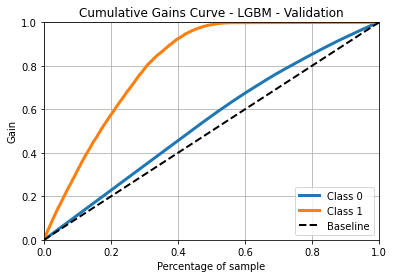

In [455]:
# LGBM
skplt.metrics.plot_cumulative_gain(y_val, validation_model_prob, title='Cumulative Gains Curve - LGBM - Validation');

### 9.4.2. Final Model

**Join Train & Validation Dataset**

In [456]:
x_train_final = pd.concat([x_train, x_validation], axis=0)
y_train_final = pd.concat([y_train, y_val], axis=0)

**Final Model**

In [457]:
LBGM_final = LGBMClassifier(boosting_type = 'gbdt',
                            n_estimators = 194,
                            learning_rate = 0.04,
                            num_leaves = 25,
                            max_depth = 29)

# fit the model
LBGM_final.fit(x_train_final, y_train_final)

# Save trained model
pickle.dump(LBGM_final, open('C:/Users/victo/repos/Health_Insurance_Cross_Sell/src/models/model_lightgbm.pkl', 'wb'))

# <font color='darkblue'> 10. Evaluate Results </font>

## 10.1. Machine Learning Performance

### 10.1.1. Apply Model in Test Dataset

#### 10.1.1.1. Prepare Test dataset

In [458]:
# ------- DATA CLEANING -------------------------------------------------
# change columns names to lowercase
x_test.columns = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage']

# change region_code from float to int format
x_test['region_code'] = x_test['region_code'].astype('int64')

# change policy_sales_channel from float to int format
x_test['policy_sales_channel'] = x_test['policy_sales_channel'].astype('int64')


# ------- FEATURE ENGINEERING --------------------------------------------
# change vehicle_age to easy interpretation
x_test['vehicle_age'] = x_test['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 
                                                              'between_1_2_years' if x == '1-2 Year' else
                                                              'below_1_year')

# change vehicle_damage from object(yes & no) to int(1 & 0)
x_test['vehicle_damage'] = x_test['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)


# ------- DATA PREPARATION ------------------------------------------------
# stardardization
x_test['annual_premium']       = rs.transform(x_test[['annual_premium']].values)

# Rescaling
x_test['age']                  = mms_age.transform(x_test[['age']].values)

x_test['vintage']              = mms_vintage.transform(x_test[['vintage']].values)

# Encoders
x_test['gender']               = x_test['gender'].apply(lambda x: 1 if x == 'Male' else 0)

x_test['region_code']          = x_test['region_code'].map(fe)

x_test['policy_sales_channel'] = x_test['policy_sales_channel'].map(fe1)

x_test['vehicle_age']          = x_test['vehicle_age'].apply(lambda x: 0 if x == 'below_1_year' else
                                                                       1 if x == 'between_1_2_years' else
                                                                       2)

# ------- FEATURE SELECION -------------------------------------------------
# select features 
x_test = x_test[['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']]

#### 10.1.1.2. Predict Test data & Calculate Precision@k

In [459]:
# predict x_test
test_prob = LBGM_final.predict_proba(x_test)

# size of true values from target test dataset
k_size = len(y_test[y_test == 1])

# add y_val to data to create score metrics 
x_test['response'] = y_test.copy()

# propensity score
x_test['propensity_score'] = test_prob[:, 1].tolist()

# calc precision@k
test_precision_at_k = precision_at_k(x_test, k=k_size)

### 10.1.2. Compare Learning Ability & Generalizability

#### 10.1.2.1. Precision@K

In [460]:
pd.DataFrame({'Data': ['Validation', 'Test'], 'Precision@k': [validation_precision_at_k, test_precision_at_k]})

,Data,Precision@k
0,Validation,0.389
1,Test,0.329


#### 10.1.2.2. Gain & Lift Curve

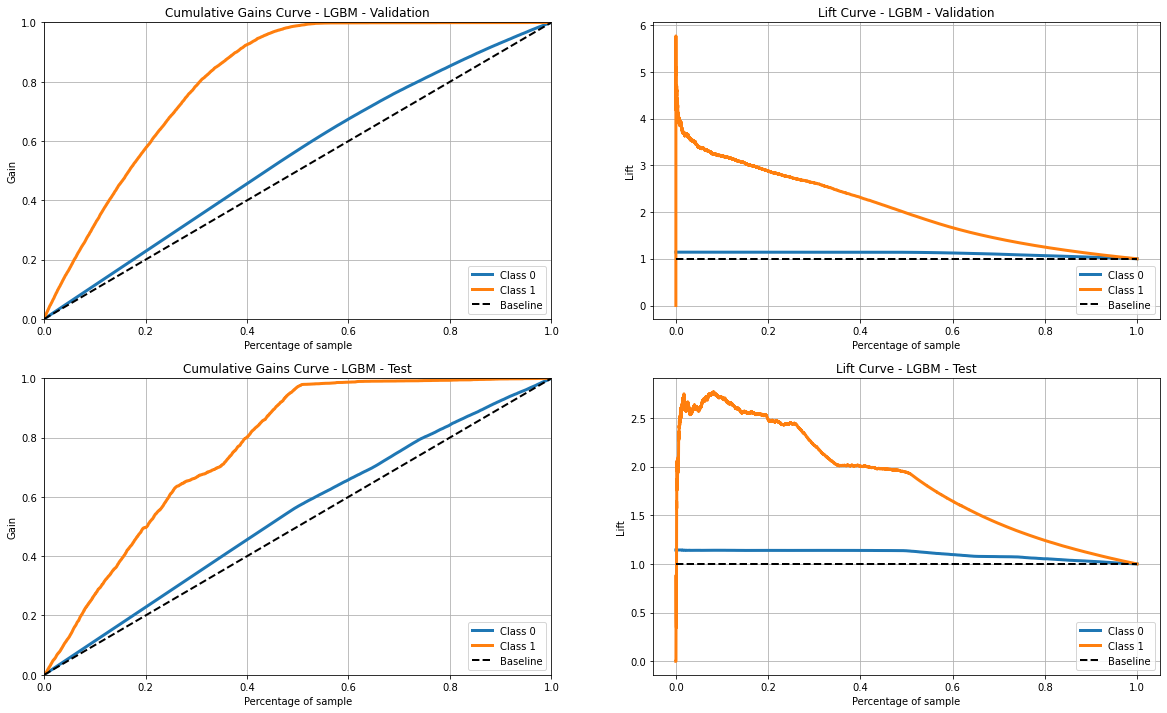

In [461]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20,12))

## Validation 
# Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, validation_model_prob, title='Cumulative Gains Curve - LGBM - Validation', ax=ax[0, 0]);

# Lift Curve
skplt.metrics.plot_lift_curve(y_val, validation_model_prob, title='Lift Curve - LGBM - Validation', ax=ax[0, 1]);

## Test 
# Gain Curve
skplt.metrics.plot_cumulative_gain(y_test, test_prob, title='Cumulative Gains Curve - LGBM - Test', ax=ax[1, 0]);

# Lift Curve
skplt.metrics.plot_lift_curve(y_test, test_prob, title='Lift Curve - LGBM - Test', ax=ax[1, 1]);

## 10.2. Business Performance

In [151]:
# read production data using pandas df
df_prod = pd.read_csv('../data/test.csv')

### 10.2.1. Percentage of customers interested in vehicle insurance in 20,000 calls

In [501]:
calls_20k = (20000*100) / len(df_prod)
print(f'20000 calls represent {calls_20k:.2f}% of customers in the dataset')

20000 calls represent 15.74% of customers in the dataset


With 20000 calls we can contact 40% of the interested customers in the dataset


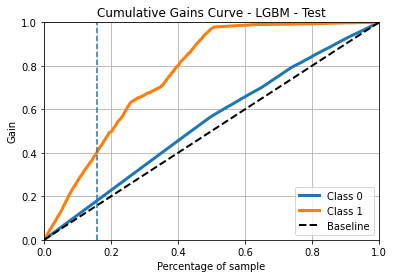

In [502]:
# Gain Curve
skplt.metrics.plot_cumulative_gain(y_test, test_prob, title='Cumulative Gains Curve - LGBM - Test');
plt.axvline(x=0.1574).set_linestyle('--')

print('With 20000 calls we can contact 40% of the interested customers in the dataset')

With 20000 calls our result will be 2.6x better than the aleatory result


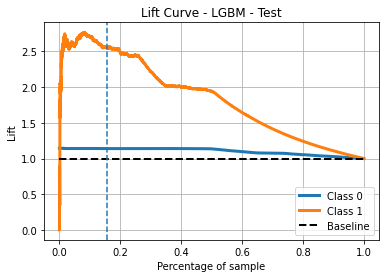

In [503]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_test, test_prob, title='Lift Curve - LGBM - Test');
plt.axvline(x=0.1574).set_linestyle('--')

print('With 20000 calls our result will be 2.6x better than the aleatory result')

### 10.2.2. Percentage of customers interested in vehicle insurance in 40,000 calls

In [465]:
calls_40k = (40000*100) / len(df_prod)
print(f'40000 calls represent {calls_40k:.2f}% of customers in the dataset')

40000 calls represent 31.49% of customers in the dataset


With 40000 calls we can contact 69% of the interested customers in the dataset


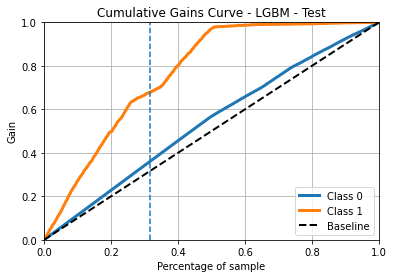

In [466]:
skplt.metrics.plot_cumulative_gain(y_test, test_prob, title='Cumulative Gains Curve - LGBM - Test');
plt.axvline(x=0.3149).set_linestyle('--')

print('With 40000 calls we can contact 69% of the interested customers in the dataset')

With 40000 calls our result will be 2.2x better than the aleatory result


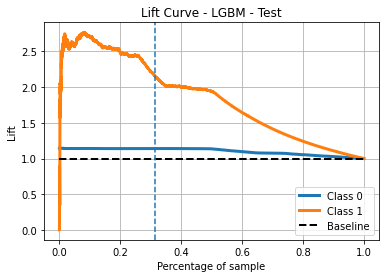

In [467]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_test, test_prob, title='Lift Curve - LGBM - Test');
plt.axvline(x=0.3149, linestyle='--')

print('With 40000 calls our result will be 2.2x better than the aleatory result')

### 10.2.3. Number of calls needed to contact 80% of those interested in vehicle insurance

80% of interested customers represents 38% of the customers in the dataset.
Will be necessary 48274 calls to contact 80% of the customers interested in the vehicle insurance.


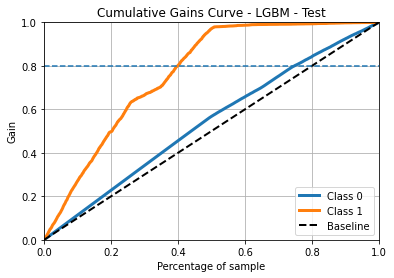

In [468]:
skplt.metrics.plot_cumulative_gain(y_test, test_prob, title='Cumulative Gains Curve - LGBM - Test');
plt.axhline(y=0.8, linestyle='--')

print('80% of interested customers represents 38% of the customers in the dataset.')
print(f'Will be necessary {len(df_prod) * 0.38:.0f} calls to contact 80% of the customers interested in the vehicle insurance.')

# <font color='darkblue'> 11. Deploy </font>

## 11.1. Health Insurance Class

In [469]:
class HealthInsurance:
    
    def __init__(self):
        
        self.home_path = 'C:/Users/victo/repos/Health_Insurance_Cross_Sell/development/'
        self.annual_premium_scaler         = pickle.load(open(self.home_path + 'src/transformations/annual_premium_scaler.pkl', 'rb'))
        self.age_scaler                    = pickle.load(open(self.home_path + 'src/transformations/age_scaler.pkl', 'rb'))
        self.vintage_scaler                = pickle.load(open(self.home_path + 'src/transformations/age_scaler.pkl', 'rb'))
        self.region_code_encoder           = pickle.load(open(self.home_path + 'src/transformations/region_code_encoder.pkl', 'rb'))
        self.policy_sales_channel_encoder  = pickle.load(open(self.home_path + 'src/transformations/policy_sales_channel_encoder.pkl', 'rb'))
        
        
    def data_cleaning(self, data):
        
        # ordered columns
        data = data[['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']]
        
        # change columns names to lowercase
        data.columns = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage']
    
        # change region_code from float to int format
        data['region_code'] = data['region_code'].astype('int64')

        # change policy_sales_channel from float to int format
        data['policy_sales_channel'] = data['policy_sales_channel'].astype('int64')
        
        return data
    
    
    def feature_engineering(self, data):
        
        # change vehicle_age to easy interpretation
        data['vehicle_age'] = data['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 
                                                                  'between_1_2_years' if x == '1-2 Year' else
                                                                  'below_1_year')

        # change vehicle_damage from object(yes & no) to int(1 & 0)
        data['vehicle_damage'] = data['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        
        return data
    
    def data_preparation(self, data):
    
        # annual_premium
        data['annual_premium'] = self.annual_premium_scaler.transform(data[['annual_premium']].values)
        
        # age
        data['age'] = self.age_scaler.transform(data[['age']].values)

        # vintage
        data['vintage'] = self.vintage_scaler.transform(data[['vintage']].values)              

        # gender
        data['gender'] = data['gender'].apply(lambda x: 1 if x == 'Male' else 0)            
        
        # vehicle age
        data['vehicle_age'] = data['vehicle_age'].apply(lambda x: 0 if x == 'below_1_year' else
                                                                  1 if x == 'between_1_2_years' else
                                                                  2)         
        
        # region code
        data['region_code'] = data['region_code'].map(self.region_code_encoder)
                
        # Policy Sales Channel
        data['policy_sales_channel'] = data['policy_sales_channel'].map(self.policy_sales_channel_encoder)
        
        # select features 
        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']   
        
        return data[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        
        # model prediction
        pred = model.predict_proba(test_data)
        
        # join prediction into original data
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json(orient = 'records', date_format = 'iso')

## 11.2. API Handler

In [480]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

# load model
path = 'C:/Users/victo/repos/Health_Insurance_Cross_Sell/development/'
model = pickle.load(open(path + 'src/models/model_lightgbm.pkl', 'rb'))


# Initialize API
app = Flask(__name__)

# create a route
@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    
    # get data
    test_json = request.get_json()
    
    # there is data
    if test_json:
        
        # unique example
        if isinstance(test_json, dict): 
            test_raw = pd.DataFrame(test_json, index=[0])
            
        # multiple examples
        else: 
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instantiate Health Insurance class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    # there isn't data
    else:
        return Response('{}', status=200, mimetype='application/json')
    
# run API
if __name__ == '__main__':
    app.run('127.0.0.1', debug=True)

## 11.3. API Tester

In [150]:
import requests

In [151]:
# loading test dataset
df_test = pd.read_csv('../data/test.csv')

In [152]:
# choose some examples
df_test = df_test.sample(10)

In [153]:
# convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [154]:
# # API call
# address
#url = 'http://127.0.0.1:5000/predict'
url = 'https://health-insurance-c-s.herokuapp.com/predict'
# indicate api that is a json
header = {'Content-type': 'application/json'}

In [155]:
# call the api
r = requests.post(url, data=data, headers=header)

In [156]:
# return the status code
print(f'Status Code {r.status_code}')

Status Code 200


In [157]:
# convert json to dataframe
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

# sort by score and show the dataframe
d1.sort_values('score', ascending=False).head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,score
6,415625,Female,33,1,36.000,0,1-2 Year,Yes,45739.000,124.000,70,0.402
5,394874,Male,22,1,36.000,0,< 1 Year,Yes,35365.000,152.000,218,0.095
3,395259,Female,37,1,11.000,0,< 1 Year,No,2630.000,1.000,151,0.048
1,421570,Female,50,1,36.000,0,1-2 Year,No,37037.000,124.000,173,0.030
9,503299,Male,38,1,33.000,1,1-2 Year,No,40111.000,124.000,112,0.001


## 11.4. Google Script

In [478]:
// Button to get predictions
function onOpen() {
  var ui = SpreadsheetApp.getUi();
  ui.createMenu( 'Health Insurance Prediction' )
    .addItem( 'Get Prediction', 'PredictAll')
    .addToUi();  
}

// Production Server
host_production = 'health-insurance-c-s.herokuapp.com'

// ----------------------------
// ----- Helper Function ------
// ----------------------------

// API Call
function ApiCall( data, endpoint ){
  var url = 'https://' + host_production + endpoint;
  var payload = JSON.stringify( data );

  var options = {'method': 'POST', 'contentType': 'application/json', 'payload': payload};

  Logger.log( url )
  Logger.log( options )

  var response = UrlFetchApp.fetch( url, options );

  // get response
  var rc = response.getResponseCode();
  var responseText = response.getContentText();

  if ( rc !== 200 ){
    Logger.log( 'Response (%s) %s', rc, responseText );
  }
  else{
    prediction = JSON.parse( responseText );
  }
  return prediction
};

// Health Insurance Propensity Score Prediction
function PredictAll(){
  //google sheets parameters
  var ss = SpreadsheetApp.getActiveSheet();
  var titleColumns = ss.getRange( 'A1:K1' ).getValues()[0];
  var lastRow = ss.getLastRow();
  
  var data = ss.getRange( 'A2' + ':' + 'K' + lastRow ).getValues();

  // run over all rows
  for ( row in data ){
    var json = new Object();

    // run over all columns
    for( var j=0; j < titleColumns.length; j++ ){
      json[titleColumns[j]] = data[row][j];
    };

    // Json file to send
    var json_send = new Object();
    json_send['id'] = json['id']
    json_send['Gender'] = json['Gender']
    json_send['Age'] =  json['Age']
    json_send['Driving_License'] = json['Driving_License']
    json_send['Region_Code'] = json['Region_Code']
    json_send['Previously_Insured'] = json['Previously_Insured']
    json_send['Vehicle_Age'] = json['Vehicle_Age']
    json_send['Vehicle_Damage'] = json['Vehicle_Damage']
    json_send['Annual_Premium'] = json['Annual_Premium']
    json_send['Policy_Sales_Channel'] = json['Policy_Sales_Channel']
    json_send['Vintage'] = json['Vintage']

    // Propensity score
    pred = ApiCall( json_send, '/predict' );

    // Send back to google sheets
    ss.getRange( Number( row ) + 2 , 12 ).setValue( pred[0]['score'] )
    Logger.log( pred[0]['score'] )
    Logger.log( row )
  };

### 11.4.1. Google Sheets Interface

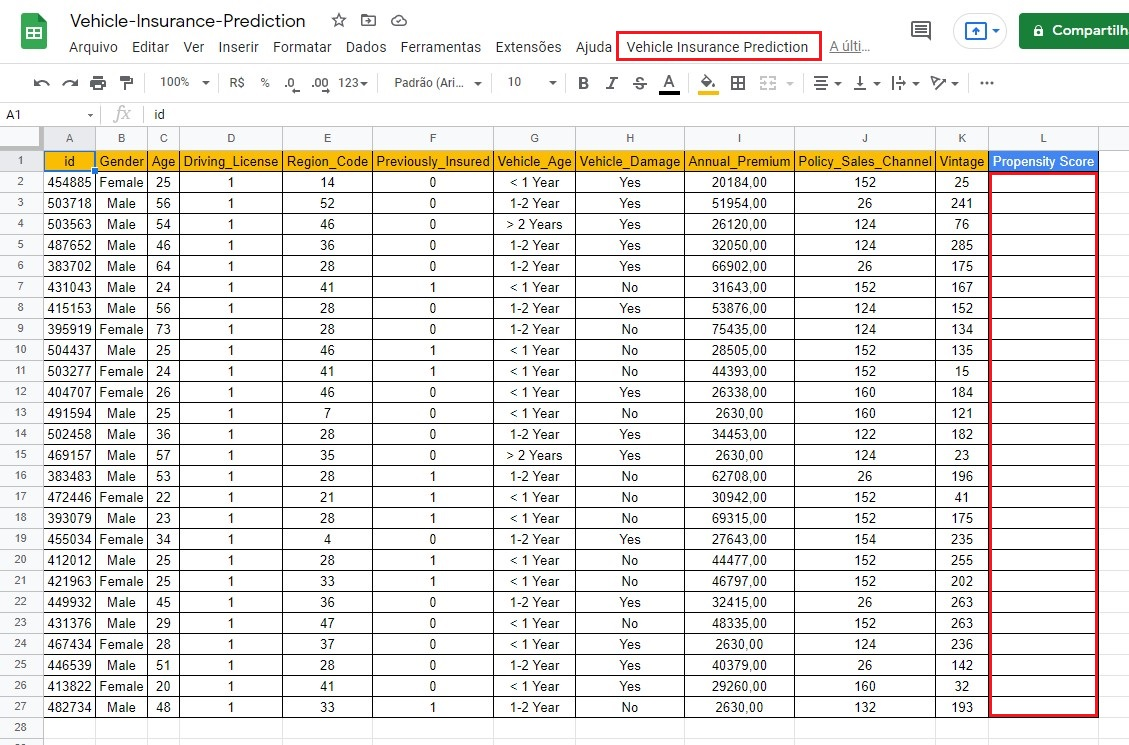

In [479]:
Image("../images/GSheets.jpg")